# **Predicción de Conversión de Leads Usando Machine Learning**
### **Introducción**

En la era digital, las empresas enfrentan el desafío constante de identificar y priorizar a los clientes con mayor probabilidad de conversión. El análisis de datos masivos y la automatización de procesos han permitido abordar este desafío mediante modelos avanzados de Machine Learning.

En este proyecto, exploramos la predicción de conversión de leads, una tarea fundamental en estrategias de marketing digital. Utilizando técnicas como **Random Forest** y **XGBoost**, diseñaremos un modelo capaz de clasificar leads con base en características relevantes, optimizando así las decisiones estratégicas.

### **Objetivos del Proyecto**
- Desarrollar un modelo de Machine Learning que prediga la probabilidad de conversión de un lead.
- Implementar un flujo de trabajo de datos realista, incluyendo procesos **ETL** y el uso de herramientas como **Google BigQuery** para la gestión y transformación de datos.
- Comparar el rendimiento de modelos clásicos como Random Forest con algoritmos avanzados como XGBoost.
- Crear una solución aplicable al entorno empresarial, capaz de ser integrada en procesos automatizados.

### **Flujo de Trabajo**
1. **Preparación del Dataset**: Limpieza, análisis exploratorio y transformación de los datos.
2. **Entrenamiento de Modelos**: Construcción de modelos de clasificación y ajuste de hiperparámetros.
3. **Evaluación de Resultados**: Uso de métricas como precisión, F1-Score y AUC-ROC para comparar modelos.
4. **Visualización e Implementación**: Creación de dashboards interactivos y automatización del pipeline.

Este notebook no solo busca resolver un problema técnico, sino también ofrecer un marco replicable y aplicable en el ámbito real, donde los insights generados por el modelo pueden traducirse en acciones empresariales efectivas.


In [441]:
#Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import io
import os
from google.cloud import bigquery
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [442]:
# Importar librerías necesarias
from google.cloud import storage, bigquery
import os
import pandas as pd
import io

# Configuración del bucket y credenciales
BUCKET_NAME = "tfg_credencial"
CREDENTIALS_FILE = "tfg-key.json"
#--------Linux o Mac------- Descomentar
#LOCAL_CREDENTIALS_PATH = "/tmp/credentials.json"

#--------Windows------- Descomentar
LOCAL_CREDENTIALS_PATH = r"C:\Users\DYLAN\Desktop\tfg-key.json"


# Función para descargar credenciales desde GCS
def download_credentials():
    if not os.path.exists(LOCAL_CREDENTIALS_PATH):
        client = storage.Client()
        bucket = client.bucket(BUCKET_NAME)
        blob = bucket.blob(CREDENTIALS_FILE)

        print("Descargando credenciales desde GCS...")
        blob.download_to_filename(LOCAL_CREDENTIALS_PATH)
        print("Credenciales descargadas y guardadas en:", LOCAL_CREDENTIALS_PATH)
    else:
        print("Credenciales ya existen en el sistema.")

    # Configurar credenciales en la variable de entorno
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = LOCAL_CREDENTIALS_PATH
    print("Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.")

# Llamar a la función para descargar credenciales
download_credentials()

# Inicializar el cliente de BigQuery
client = bigquery.Client()

# Nombre de la tabla en BigQuery
table_id = "future-loader-433707-h4.leads.tabla_entrenamiento_60_40"

# Consultar los datos de la tabla
query = f"SELECT * FROM `{table_id}`"

try:
    # Ejecutar la consulta y convertir el resultado a un DataFrame
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    # Guardar el DataFrame en un archivo CSV en memoria
    memory_file = io.StringIO()
    df.to_csv(memory_file, index=False)
    memory_file.seek(0)

    # Leer el archivo en memoria nuevamente como un DataFrame
    data_frame_leads = pd.read_csv(memory_file)
    print("Tabla cargada en memoria y leída en una variable temporal (DataFrame).")
except Exception as e:
    print(f"Error al descargar la tabla: {e}")

# Configuración para mejorar la visualización del DataFrame
pd.set_option('display.max_columns', None)  # Muestra todas las columnas
pd.set_option('display.max_rows', 20)       # Número de filas (ajustable)
pd.set_option('display.width', 1000)        # Evitar saltos de línea
print(data_frame_leads.head())  # Imprimir las primeras filas formateadas


Credenciales ya existen en el sistema.
Credenciales configuradas en GOOGLE_APPLICATION_CREDENTIALS.


c:\Users\DYLAN\anaconda3\envs\entornoConda\lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Tabla cargada en memoria y leída en una variable temporal (DataFrame).
   Lead Number              Lead Origin     Lead Source  Converted  Total Time Spent on Website  Page Views Per Visit            Last Activity What is your current occupation  A free copy of Mastering The Interview                                 Tags               City Asymmetrique Activity Index Asymmetrique Profile Index  Asymmetrique Activity Score  Asymmetrique Profile Score Last Notable Activity  TotalVisits  Country           Specialization  Average Time Per Visit     rn  total_conversions  total_no_conversions
0       773419                      API  Direct Traffic          1                           39                  0.26  Olark Chat Conversation                         Unknown                                   False                              Ringing  Thane & Outskirts                         NaN                     03.Low                         15.0                         NaN          Email Opened 

 # **1.Preparación del Dataset**: 

In [443]:
#Revisión general del data frame
print(data_frame_leads.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114470 entries, 0 to 114469
Data columns (total 23 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Lead Number                             114470 non-null  int64  
 1   Lead Origin                             114470 non-null  object 
 2   Lead Source                             113999 non-null  object 
 3   Converted                               114470 non-null  int64  
 4   Total Time Spent on Website             114470 non-null  int64  
 5   Page Views Per Visit                    114470 non-null  float64
 6   Last Activity                           113107 non-null  object 
 7   What is your current occupation         114470 non-null  object 
 8   A free copy of Mastering The Interview  114470 non-null  bool   
 9   Tags                                    114470 non-null  object 
 10  City                                    1144

In [444]:
print(data_frame_leads.isnull().sum())

Lead Number                        0
Lead Origin                        0
Lead Source                      471
Converted                          0
Total Time Spent on Website        0
                               ...  
Specialization                     0
Average Time Per Visit         16394
rn                                 0
total_conversions                  0
total_no_conversions               0
Length: 23, dtype: int64


In [445]:
data_frame_leads.dtypes

Lead Number                      int64
Lead Origin                     object
Lead Source                     object
Converted                        int64
Total Time Spent on Website      int64
                                ...   
Specialization                  object
Average Time Per Visit         float64
rn                               int64
total_conversions                int64
total_no_conversions             int64
Length: 23, dtype: object

In [446]:
data_frame_leads.describe()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score,TotalVisits,Average Time Per Visit,rn,total_conversions,total_no_conversions
count,114470.000000,114470.000000,114470.000000,114470.000000,61960.000000,61316.000000,114470.000000,98076.00000,114470.000000,114470.0,114470.0
mean,549390.685306,0.598803,279.426645,1.515899,14.299500,16.350724,2.122399,101.34194,29735.463964,68545.0,101958.0
std,260424.887872,0.490143,385.921196,1.556238,1.036271,1.820954,1.713219,97.67705,18322.100287,0.0,0.0
min,100002.000000,0.000000,1.000000,0.000000,10.000000,11.000000,0.000000,0.50000,1.000000,68545.0,101958.0
25%,323115.000000,0.000000,11.000000,0.280000,14.000000,15.000000,1.000000,21.00000,14309.250000,68545.0,101958.0
50%,549578.000000,1.000000,87.000000,0.890000,14.000000,16.000000,2.000000,72.00000,28618.000000,68545.0,101958.0
75%,775335.250000,1.000000,416.000000,2.350000,15.000000,18.000000,3.000000,158.00000,42926.750000,68545.0,101958.0
max,999996.000000,1.000000,2143.000000,6.000000,18.000000,20.000000,10.000000,985.00000,68545.000000,68545.0,101958.0


In [447]:
print(data_frame_leads['Specialization'].value_counts())

print("------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION-----------------------------")

porcentaje_select = (data_frame_leads['Specialization'] == 'Select').mean() * 100
print(f"Porcentaje de 'Select': {porcentaje_select:.2f}%")

print("------------------------------------------ANALISIS DE LA TASA DE CONVERSION----------------------------------------")

conversion_select = data_frame_leads[data_frame_leads['Specialization'] == 'Select']['Converted'].mean()
print(f"Tasa de conversión para 'Select': {conversion_select:.2f}")


Specialization
Select                               25828
Finance Management                   13134
Marketing Management                 11205
Human Resource Management            11181
Unknown                              10586
Operations Management                 6640
Business Administration               5309
IT Projects Management                4924
Supply Chain Management               4727
Banking, Investment And Insurance     4579
Media and Advertising                 2698
Travel and Tourism                    2620
International Business                2440
Healthcare Management                 2071
E-COMMERCE                            1502
Hospitality Management                1417
Retail Management                     1382
Rural and Agribusiness                1020
E-Business                             745
Services Excellence                    462
Name: count, dtype: int64
------------------------REVISAR PORCENTAJES DE SELECT EN LA COLUMNA DE SPECIALIZATION--------------

Si el modelo aprende que los leads con "Select" tienen una tasa de conversión extremadamente baja, solo estará utilizando este dato como un indicador trivial y no como una característica que realmente aporte valor para predecir conversiones en general.

Esto podría derivar en un modelo que:

Detecte patrones obvios: Como "Si Specialization = Select, entonces conversión ≈ 0".
Pierda generalización: Porque el modelo no estaría aprendiendo sobre las características relevantes de los leads que realmente convierten.

In [448]:
# Eliminar filas donde 'Specialization' sea 'Select'
data_frame_leads = data_frame_leads[data_frame_leads['Specialization'] != 'Select']

# Verificar el tamaño del dataset después
print(f"Cantidad de filas después de eliminar 'Select': {len(data_frame_leads)}")


Cantidad de filas después de eliminar 'Select': 88642


In [449]:
# Verificar columnas con valores nulos
print(data_frame_leads.isnull().sum())

print("--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------")
# Analizar el porcentaje de valores nulos por columna
percent_missing = (data_frame_leads.isnull().sum() / len(data_frame_leads)) * 100
print(percent_missing)

#Analizando el volumen de nulos que tienen las columnas y viendo que no nos van  a aportar nada a los modeos de Machine Learning se van a eliminar las columnas con un 40 por ciento de valore nulos

# Eliminar columnas con más del 40% de valores nulos
columns_to_drop = percent_missing[percent_missing > 40].index
data_frame_leads.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columnas eliminadas: {list(columns_to_drop)}")




Lead Number                        0
Lead Origin                        0
Lead Source                      358
Converted                          0
Total Time Spent on Website        0
                               ...  
Specialization                     0
Average Time Per Visit         12689
rn                                 0
total_conversions                  0
total_no_conversions               0
Length: 23, dtype: int64
--------------COLUMNAS CON UN VALOR ALTO DE NULOS---------------
Lead Number                     0.000000
Lead Origin                     0.000000
Lead Source                     0.403872
Converted                       0.000000
Total Time Spent on Website     0.000000
                                 ...    
Specialization                  0.000000
Average Time Per Visit         14.314885
rn                              0.000000
total_conversions               0.000000
total_no_conversions            0.000000
Length: 23, dtype: float64
Columnas eliminadas: ['As

In [450]:
# Reemplazar valores nulos en columnas categóricas y numéricas
data_frame_leads['City'].fillna('Unknown', inplace=True)
data_frame_leads['What is your current occupation'].fillna('Unknown', inplace=True)
data_frame_leads['Tags'].fillna('Unknown', inplace=True)

# Para numéricos, utilizar la media
data_frame_leads['Page Views Per Visit'].fillna(data_frame_leads['Page Views Per Visit'].mean(), inplace=True)
data_frame_leads['Last Activity'].fillna('Unknown', inplace=True)

print("Valores nulos reemplazados correctamente.")


Valores nulos reemplazados correctamente.


In [451]:
# Eliminar filas con valores nulos en columnas críticas
data_frame_leads.dropna(subset=['Lead Source'], inplace=True)
print(f"Cantidad de filas después de eliminar filas con nulos: {len(data_frame_leads)}")

#Poner la media en los pocos valores nulos que hay en la dimension Average Time Per Visit
data_frame_leads['Average Time Per Visit'].fillna(data_frame_leads['Average Time Per Visit'].mean(), inplace=True)


print("-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------")

# Verificar que no quedan valores nulos
print(data_frame_leads.isnull().sum())



Cantidad de filas después de eliminar filas con nulos: 88284
-------------------------------------VALIDAR QUE NO QUEDAN VALORES NULOS--------------------------------
Lead Number                               0
Lead Origin                               0
Lead Source                               0
Converted                                 0
Total Time Spent on Website               0
Page Views Per Visit                      0
Last Activity                             0
What is your current occupation           0
A free copy of Mastering The Interview    0
Tags                                      0
City                                      0
Last Notable Activity                     0
TotalVisits                               0
Country                                   0
Specialization                            0
Average Time Per Visit                    0
rn                                        0
total_conversions                         0
total_no_conversions                      

# **1.1 Analisis mediante graficas de cada dimension**

**LEAD ORIGIN**

In [452]:
data_frame_leads['Lead Origin'].unique()

array(['API', 'Landing Page Submission', 'Lead Add Form', 'Lead Import',
       'Quick Add Form'], dtype=object)

In [453]:
data_frame_leads['Lead Origin'].value_counts()

Lead Origin
Landing Page Submission    48187
API                        31819
Lead Add Form               7625
Lead Import                  645
Quick Add Form                 8
Name: count, dtype: int64

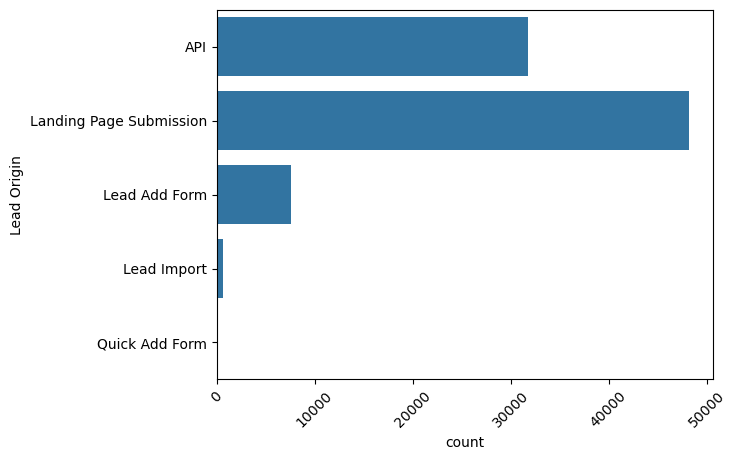

In [454]:
sns.countplot(data_frame_leads['Lead Origin'])
plt.xticks(rotation=45)
plt.show()

**Lead Source**

In [455]:
data_frame_leads['Lead Source'].unique()

array(['Direct Traffic', 'Organic Search', 'Google', 'Olark Chat',
       'Reference', 'Welingak Website', 'Facebook', 'Referral Sites',
       'bing', 'Press_Release', 'Click2call', 'google', 'blog', 'NC_EDM',
       'WeLearn', 'welearnblog_Home', 'Live Chat', 'Social Media',
       'testone', 'Pay per Click Ads', 'youtubechannel'], dtype=object)

In [456]:
data_frame_leads['Lead Source'].value_counts()

Lead Source
Google            30163
Direct Traffic    24897
Olark Chat        13391
Organic Search    10379
Reference          5697
                  ...  
WeLearn              11
blog                 10
testone               9
youtubechannel        9
NC_EDM                8
Name: count, Length: 21, dtype: int64

In [457]:
data_frame_leads['Lead Source'] = data_frame_leads['Lead Source'].fillna("Google")

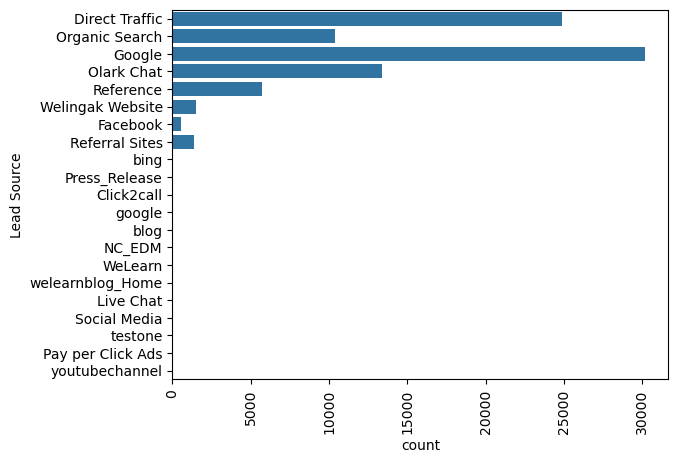

In [458]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=90)
plt.show()

In [459]:
#Revisando por porcentaje de distribución
LeadSourceCol=(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

Lead Source
Google            34.165874
Direct Traffic    28.201033
Olark Chat        15.168094
Organic Search    11.756377
Reference          6.453038
                    ...    
WeLearn            0.012460
blog               0.011327
testone            0.010194
youtubechannel     0.010194
NC_EDM             0.009062
Name: count, Length: 21, dtype: float64

In [460]:
#Cargar columnas que tengan menos de 10% de los valores
LeadSourceCol=LeadSourceCol[LeadSourceCol<10]
LeadSourceCol

Lead Source
Reference            6.453038
Welingak Website     1.739840
Referral Sites       1.548412
Facebook             0.654705
bing                 0.065697
google               0.061166
Click2call           0.045308
Social Media         0.026052
Press_Release        0.016991
Live Chat            0.016991
welearnblog_Home     0.013592
Pay per Click Ads    0.013592
WeLearn              0.012460
blog                 0.011327
testone              0.010194
youtubechannel       0.010194
NC_EDM               0.009062
Name: count, dtype: float64

Como vemos hay muchas columnas que no nos aportan nada porque aparecen muy muy pocas veces, por lo que lo suyo es construir un dato llamado " other source" que las haga referencia a ellas.

In [461]:
for i in LeadSourceCol.index:
    data_frame_leads.loc[(data_frame_leads['Lead Source'] == i),'Lead Source']='Other Source'

In [462]:
#Revisando porcentajes de distribucion para corrobar que hemos reducido el ruido de esta columna
(data_frame_leads['Lead Source'].value_counts()*100)/data_frame_leads.shape[0]

Lead Source
Google            34.165874
Direct Traffic    28.201033
Olark Chat        15.168094
Organic Search    11.756377
Other Source      10.708622
Name: count, dtype: float64

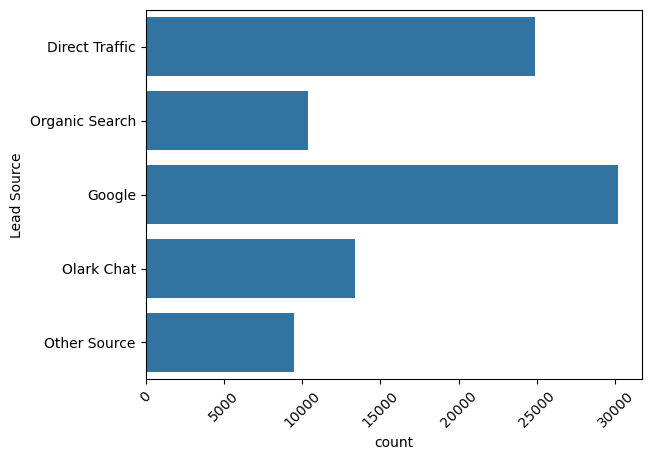

In [463]:
sns.countplot(data_frame_leads['Lead Source'])
plt.xticks(rotation=45)
plt.show()

**Last Activity**

In [464]:
data_frame_leads['Last Activity'].unique()

array(['Olark Chat Conversation', 'Email Opened', 'SMS Sent',
       'Email Link Clicked', 'Unknown', 'Email Bounced',
       'Converted to Lead', 'Page Visited on Website',
       'Had a Phone Conversation', 'Unsubscribed',
       'Form Submitted on Website', 'Unreachable', 'Approached upfront',
       'View in browser link Clicked', 'Email Received',
       'Resubscribed to emails', 'Visited Booth in Tradeshow',
       'Email Marked Spam'], dtype=object)

In [465]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    31651
SMS Sent                        27805
Olark Chat Conversation          9174
Page Visited on Website          5552
Converted to Lead                4072
Email Bounced                    3174
Email Link Clicked               2554
Form Submitted on Website        1169
Unknown                          1060
Unreachable                       901
Unsubscribed                      669
Had a Phone Conversation          288
Approached upfront                 83
View in browser link Clicked       66
Email Received                     25
Resubscribed to emails             16
Visited Booth in Tradeshow         13
Email Marked Spam                  12
Name: count, dtype: int64

In [466]:
#Llenamos posibles nulos con el valor mas comun en la columna Last Activity
data_frame_leads['Last Activity'] = data_frame_leads['Last Activity'].replace(np.nan, 'Email Opened')

In [467]:
data_frame_leads['Last Activity'].value_counts()

Last Activity
Email Opened                    31651
SMS Sent                        27805
Olark Chat Conversation          9174
Page Visited on Website          5552
Converted to Lead                4072
Email Bounced                    3174
Email Link Clicked               2554
Form Submitted on Website        1169
Unknown                          1060
Unreachable                       901
Unsubscribed                      669
Had a Phone Conversation          288
Approached upfront                 83
View in browser link Clicked       66
Email Received                     25
Resubscribed to emails             16
Visited Booth in Tradeshow         13
Email Marked Spam                  12
Name: count, dtype: int64

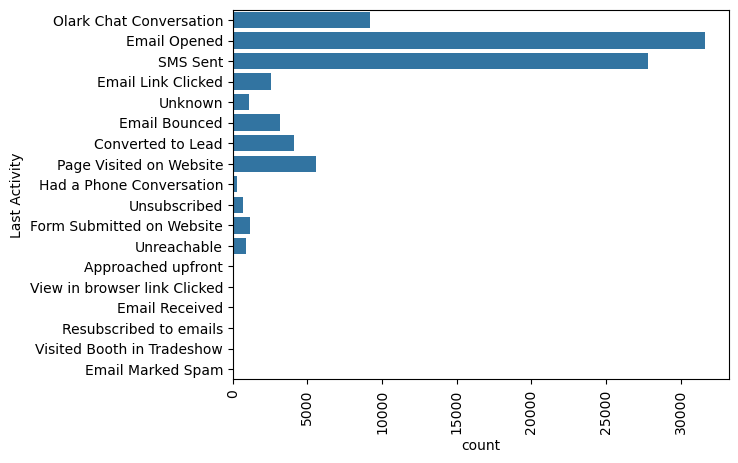

In [468]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

In [469]:
#Revisando el porcentaje de distribucion de esta columna
LastActivityCol=(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]
LastActivityCol

Last Activity
Email Opened                    35.851343
SMS Sent                        31.494948
Olark Chat Conversation         10.391464
Page Visited on Website          6.288795
Converted to Lead                4.612387
Email Bounced                    3.595215
Email Link Clicked               2.892936
Form Submitted on Website        1.324136
Unknown                          1.200671
Unreachable                      1.020570
Unsubscribed                     0.757782
Had a Phone Conversation         0.326220
Approached upfront               0.094015
View in browser link Clicked     0.074759
Email Received                   0.028318
Resubscribed to emails           0.018123
Visited Booth in Tradeshow       0.014725
Email Marked Spam                0.013592
Name: count, dtype: float64

In [470]:
#Last Activity Columns having less than 5% values
LastActivityCol=LastActivityCol[LastActivityCol<5]
LastActivityCol

Last Activity
Converted to Lead               4.612387
Email Bounced                   3.595215
Email Link Clicked              2.892936
Form Submitted on Website       1.324136
Unknown                         1.200671
Unreachable                     1.020570
Unsubscribed                    0.757782
Had a Phone Conversation        0.326220
Approached upfront              0.094015
View in browser link Clicked    0.074759
Email Received                  0.028318
Resubscribed to emails          0.018123
Visited Booth in Tradeshow      0.014725
Email Marked Spam               0.013592
Name: count, dtype: float64

In [471]:
for i in LastActivityCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Activity'] == i),'Last Activity']='Other Last Activity'

In [472]:
#Checking for percantage of distibution
(data_frame_leads['Last Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Activity
Email Opened               35.851343
SMS Sent                   31.494948
Other Last Activity        15.973449
Olark Chat Conversation    10.391464
Page Visited on Website     6.288795
Name: count, dtype: float64

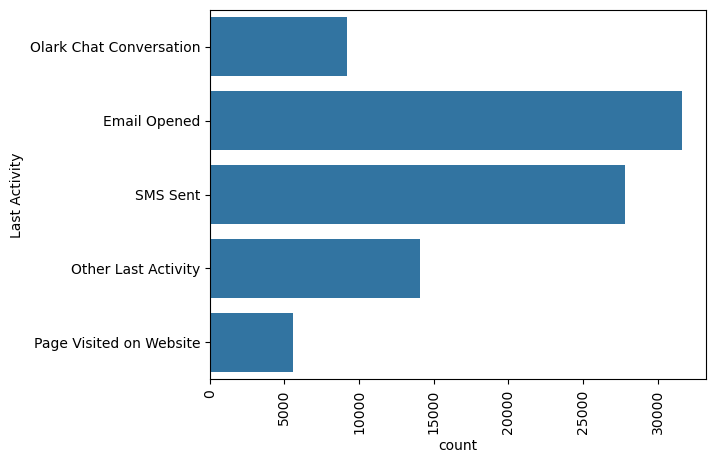

In [473]:
sns.countplot(data_frame_leads['Last Activity'])
plt.xticks(rotation=90)
plt.show()

**5.Country**

In [474]:
data_frame_leads['Country'].unique()

array(['India', 'Unknown', 'United States', 'United Arab Emirates',
       'unknown', 'Sweden', 'Qatar', 'China', 'Saudi Arabia', 'Australia',
       'Singapore', 'Nigeria', 'United Kingdom', 'Hong Kong', 'Russia',
       'Sri Lanka', 'Belgium', 'Oman', 'Kuwait', 'Bahrain',
       'South Africa', 'France', 'Germany', 'Canada',
       'Asia/Pacific Region', 'Ghana', 'Netherlands', 'Switzerland',
       'Indonesia', 'Uganda', 'Denmark', 'Tanzania', 'Liberia',
       'Bangladesh', 'Italy'], dtype=object)

In [475]:
data_frame_leads['Country'].value_counts()

Country
India                   71338
Unknown                 15690
United States             361
United Arab Emirates      296
Singapore                  91
                        ...  
Italy                       2
Indonesia                   1
Denmark                     1
Tanzania                    1
Bangladesh                  1
Name: count, Length: 35, dtype: int64

In [476]:
#Los valores Na se sustituyen por el dato que mas aparece en este caso India
data_frame_leads['Country'] = data_frame_leads['Country'].fillna("India")

In [477]:
data_frame_leads['Country'].unique()

array(['India', 'Unknown', 'United States', 'United Arab Emirates',
       'unknown', 'Sweden', 'Qatar', 'China', 'Saudi Arabia', 'Australia',
       'Singapore', 'Nigeria', 'United Kingdom', 'Hong Kong', 'Russia',
       'Sri Lanka', 'Belgium', 'Oman', 'Kuwait', 'Bahrain',
       'South Africa', 'France', 'Germany', 'Canada',
       'Asia/Pacific Region', 'Ghana', 'Netherlands', 'Switzerland',
       'Indonesia', 'Uganda', 'Denmark', 'Tanzania', 'Liberia',
       'Bangladesh', 'Italy'], dtype=object)

In [478]:
data_frame_leads['Country'].value_counts()

Country
India                   71338
Unknown                 15690
United States             361
United Arab Emirates      296
Singapore                  91
                        ...  
Italy                       2
Indonesia                   1
Denmark                     1
Tanzania                    1
Bangladesh                  1
Name: count, Length: 35, dtype: int64

In [479]:
# borramos la columna country porque solo  hay datos de la india y ademas el otro volumen mas cuantioso es desconocido
data_frame_leads.drop(labels='Country',axis=1,inplace=True)

**6.Specialization**

In [480]:
data_frame_leads['Specialization'].unique()

array(['Marketing Management', 'Supply Chain Management', 'Unknown',
       'IT Projects Management', 'Travel and Tourism',
       'Human Resource Management', 'Finance Management',
       'Operations Management', 'Banking, Investment And Insurance',
       'Media and Advertising', 'Retail Management',
       'Business Administration', 'International Business',
       'Rural and Agribusiness', 'Hospitality Management', 'E-Business',
       'E-COMMERCE', 'Healthcare Management', 'Services Excellence'],
      dtype=object)

In [481]:
data_frame_leads['Specialization'] = data_frame_leads['Specialization'].replace(np.nan, 'Others')

In [482]:
data_frame_leads['Specialization'].value_counts()

Specialization
Finance Management                   13066
Marketing Management                 11161
Human Resource Management            11139
Unknown                              10542
Operations Management                 6617
Business Administration               5282
IT Projects Management                4904
Supply Chain Management               4711
Banking, Investment And Insurance     4568
Media and Advertising                 2685
Travel and Tourism                    2613
International Business                2434
Healthcare Management                 2063
E-COMMERCE                            1493
Hospitality Management                1413
Retail Management                     1373
Rural and Agribusiness                1016
E-Business                             742
Services Excellence                    462
Name: count, dtype: int64

In [483]:
#Checking for percantage of distibution
OtherCol=(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Specialization
Finance Management                   14.799964
Marketing Management                 12.642155
Human Resource Management            12.617235
Unknown                              11.941009
Operations Management                 7.495129
Business Administration               5.982964
IT Projects Management                5.554800
Supply Chain Management               5.336188
Banking, Investment And Insurance     5.174211
Media and Advertising                 3.041321
Travel and Tourism                    2.959766
International Business                2.757011
Healthcare Management                 2.336777
E-COMMERCE                            1.691133
Hospitality Management                1.600517
Retail Management                     1.555208
Rural and Agribusiness                1.150831
E-Business                            0.840469
Services Excellence                   0.523311
Name: count, dtype: float64

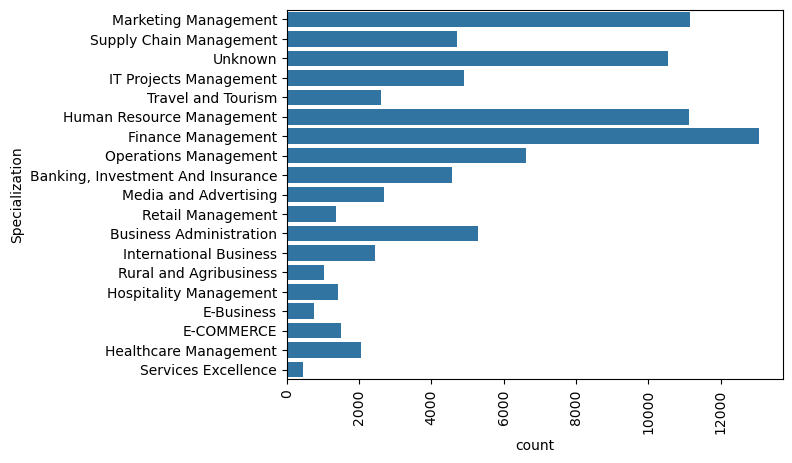

In [484]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

In [485]:
#Agrupamos los datos en una sola variable llamada Others cuando tienen un volumen inferior al 2% respecto a el volumen total de la columna Specialization

OtherCol=OtherCol[OtherCol<2]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Specialization'] == i),'Specialization']='Others'
#Checking for percantage of distibution
(data_frame_leads['Specialization'].value_counts()*100)/data_frame_leads.shape[0]


Specialization
Finance Management                   14.799964
Marketing Management                 12.642155
Human Resource Management            12.617235
Unknown                              11.941009
Operations Management                 7.495129
Others                                7.361470
Business Administration               5.982964
IT Projects Management                5.554800
Supply Chain Management               5.336188
Banking, Investment And Insurance     5.174211
Media and Advertising                 3.041321
Travel and Tourism                    2.959766
International Business                2.757011
Healthcare Management                 2.336777
Name: count, dtype: float64

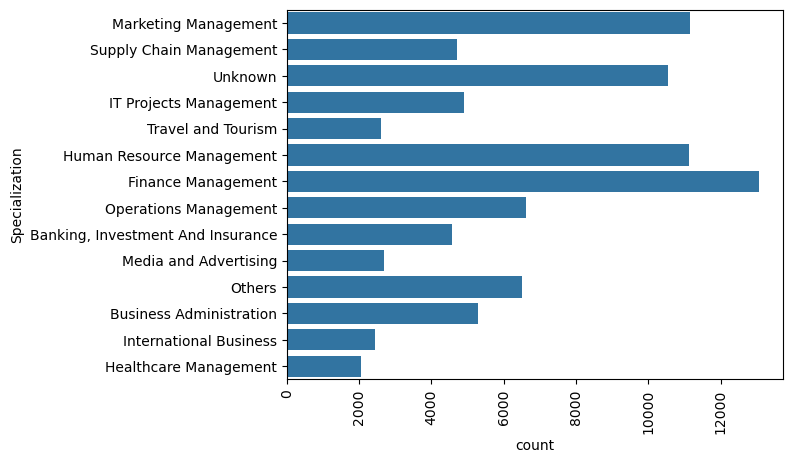

In [486]:
sns.countplot(data_frame_leads['Specialization'])
plt.xticks(rotation=90)
plt.show()

**7. WHAT IS YOUR CURRENT OCCUPATION**

In [487]:
data_frame_leads['What is your current occupation'].unique()

array(['Unknown', 'Unemployed', 'Working Professional', 'Other',
       'Housewife', 'Student', 'Businessman'], dtype=object)

In [488]:
data_frame_leads['What is your current occupation'].value_counts()

What is your current occupation
Unemployed              68619
Working Professional     8710
Unknown                  7964
Student                  2570
Other                     197
Housewife                 129
Businessman                95
Name: count, dtype: int64

In [489]:
data_frame_leads['What is your current occupation'] = data_frame_leads['What is your current occupation'].fillna("Unemployed")

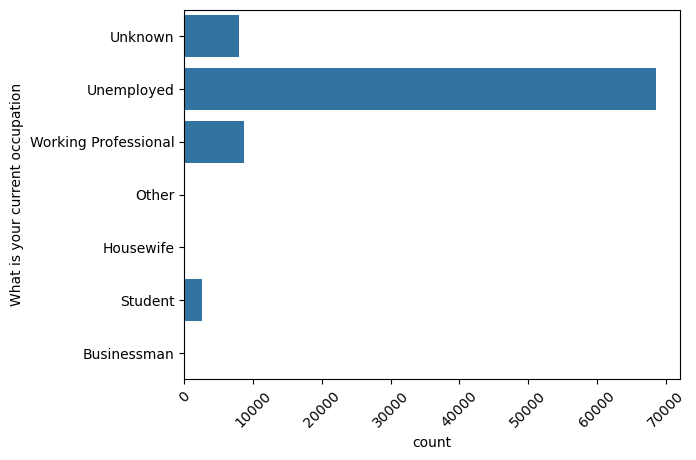

In [490]:
sns.countplot(data_frame_leads['What is your current occupation'])
plt.xticks(rotation=45)
plt.show()

In [491]:
#Revisando porcentaje de distribucion
LeadSourceCol=(data_frame_leads['What is your current occupation'].value_counts()*100)/data_frame_leads.shape[0]
LeadSourceCol

What is your current occupation
Unemployed              77.725296
Working Professional     9.865887
Unknown                  9.020887
Student                  2.911060
Other                    0.223143
Housewife                0.146119
Businessman              0.107607
Name: count, dtype: float64

**8. TAGS**

In [492]:
data_frame_leads['Tags'].unique()


array(['Ringing', 'Unknown', 'Will revert after reading the email',
       'Already a student', 'switched off', 'Closed by Horizzon',
       'Lost to EINS', 'Busy', 'Graduation in progress',
       'Interested in other courses', 'Not doing further education',
       'Diploma holder (Not Eligible)', 'Interested  in full time MBA',
       'invalid number', 'number not provided', 'wrong number given',
       'opp hangup', 'In confusion whether part time or DLP',
       'Still Thinking',
       'Want to take admission but has financial problems',
       'Recognition issue (DEC approval)', 'Lateral student',
       'in touch with EINS', 'Lost to Others',
       'Shall take in the next coming month', 'Interested in Next batch',
       'University not recognized'], dtype=object)

In [493]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    27971
Ringing                                16510
Unknown                                 8007
Interested in other courses             6933
Already a student                       6413
                                       ...  
Interested in Next batch                  61
Lateral student                           44
Shall take in the next coming month       36
University not recognized                 30
Recognition issue (DEC approval)          15
Name: count, Length: 27, dtype: int64

In [494]:
#"Will revert after reading the email" is coming the most times , hence replacing NaN value with value this.
data_frame_leads['Tags'] = data_frame_leads['Tags'].fillna("Will revert after reading the email")

In [495]:
data_frame_leads['Tags'].value_counts()

Tags
Will revert after reading the email    27971
Ringing                                16510
Unknown                                 8007
Interested in other courses             6933
Already a student                       6413
                                       ...  
Interested in Next batch                  61
Lateral student                           44
Shall take in the next coming month       36
University not recognized                 30
Recognition issue (DEC approval)          15
Name: count, Length: 27, dtype: int64

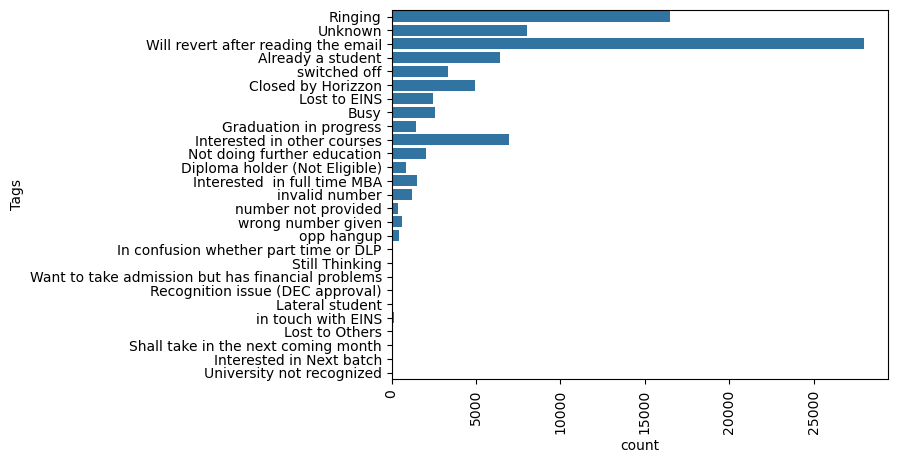

In [496]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

In [497]:
#Checking for percantage of distibution
TagsCol=(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]
TagsCol

Tags
Will revert after reading the email    31.682978
Ringing                                18.701010
Unknown                                 9.069594
Interested in other courses             7.853065
Already a student                       7.264057
                                         ...    
Interested in Next batch                0.069095
Lateral student                         0.049839
Shall take in the next coming month     0.040777
University not recognized               0.033981
Recognition issue (DEC approval)        0.016991
Name: count, Length: 27, dtype: float64

In [498]:
#Tags Columns que tienen menos de 3% values
TagsCol=TagsCol[TagsCol<3]
for i in TagsCol.index:
    data_frame_leads.loc[(data_frame_leads['Tags'] == i),'Tags']='Other Tags'

In [499]:
#Revisando de nuevo la distribución
(data_frame_leads['Tags'].value_counts()*100)/data_frame_leads.shape[0]

Tags
Will revert after reading the email    31.682978
Ringing                                18.701010
Other Tags                             16.085587
Unknown                                 9.069594
Interested in other courses             7.853065
Already a student                       7.264057
Closed by Horizzon                      5.571791
switched off                            3.771918
Name: count, dtype: float64

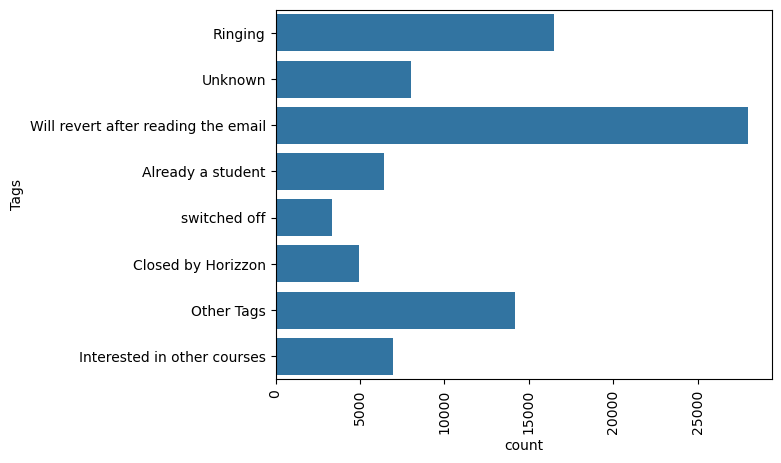

In [500]:
sns.countplot(data_frame_leads['Tags'])
plt.xticks(rotation=90)
plt.show()

**9. A FREE COPY OF MASTERING THE INTERVIEW**

In [501]:
data_frame_leads['A free copy of Mastering The Interview'].unique()

array([False,  True])

In [502]:
data_frame_leads['A free copy of Mastering The Interview'].value_counts()

A free copy of Mastering The Interview
False    59762
True     28522
Name: count, dtype: int64

C:\Users\DYLAN\AppData\Local\Temp\ipykernel_11808\4056837565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='muted')


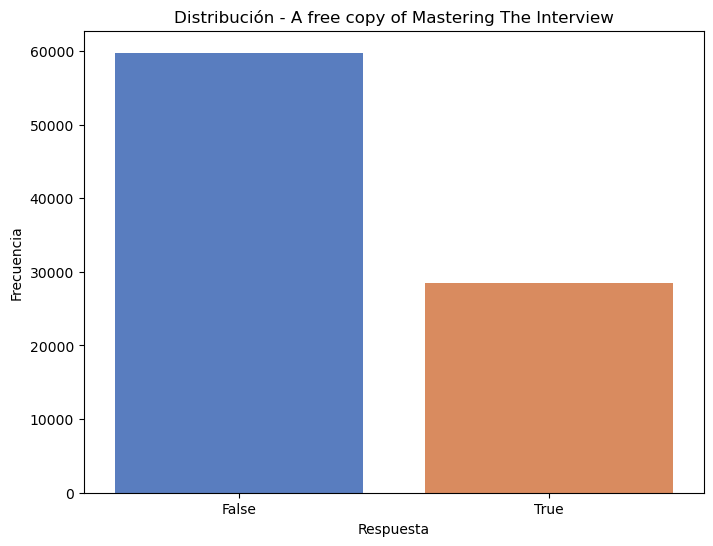

In [503]:

# Agrupar por valor y contar
counts = data_frame_leads['A free copy of Mastering The Interview'].value_counts()

# Graficar usando barplot en lugar de countplot
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.index, y=counts.values, palette='muted')

# Título y etiquetas
plt.title('Distribución - A free copy of Mastering The Interview')
plt.xlabel('Respuesta')
plt.ylabel('Frecuencia')

plt.show()


**10. LAST NOTABLE ACTIVITY**

In [504]:
data_frame_leads['Last Notable Activity'].unique()

array(['Email Opened', 'Modified', 'SMS Sent', 'Page Visited on Website',
       'Email Bounced', 'Olark Chat Conversation', 'Email Link Clicked',
       'Had a Phone Conversation', 'View in browser link Clicked',
       'Unsubscribed', 'Email Marked Spam', 'Unreachable',
       'Email Received', 'Resubscribed to emails',
       'Form Submitted on Website', 'Approached upfront'], dtype=object)

In [505]:
data_frame_leads['Last Notable Activity'].value_counts()

Last Notable Activity
Modified                        29945
Email Opened                    26663
SMS Sent                        23359
Page Visited on Website          3133
Olark Chat Conversation          1768
Email Link Clicked               1745
Email Bounced                     605
Unsubscribed                      482
Unreachable                       336
Had a Phone Conversation          145
Email Marked Spam                  28
Email Received                     19
View in browser link Clicked       18
Form Submitted on Website          16
Resubscribed to emails             11
Approached upfront                 11
Name: count, dtype: int64

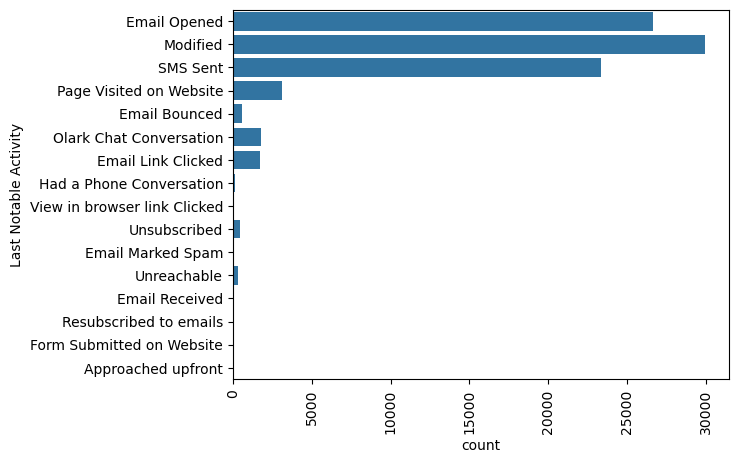

In [506]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=90)
plt.show()

In [507]:
#Revisando el porcentaje de distribucion
OtherCol=(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]
OtherCol

Last Notable Activity
Modified                        33.918943
Email Opened                    30.201395
SMS Sent                        26.458928
Page Visited on Website          3.548774
Olark Chat Conversation          2.002628
Email Link Clicked               1.976576
Email Bounced                    0.685288
Unsubscribed                     0.545965
Unreachable                      0.380590
Had a Phone Conversation         0.164243
Email Marked Spam                0.031716
Email Received                   0.021521
View in browser link Clicked     0.020389
Form Submitted on Website        0.018123
Resubscribed to emails           0.012460
Approached upfront               0.012460
Name: count, dtype: float64

In [508]:
#Agrupando las variables inferiores al 5 por ciento en una sola para reducir ruido
OtherCol=OtherCol[OtherCol<5]
for i in OtherCol.index:
    data_frame_leads.loc[(data_frame_leads['Last Notable Activity'] == i),'Last Notable Activity']='Other Activity'
#Checking for percantage of distibution
(data_frame_leads['Last Notable Activity'].value_counts()*100)/data_frame_leads.shape[0]

Last Notable Activity
Modified          33.918943
Email Opened      30.201395
SMS Sent          26.458928
Other Activity     9.420733
Name: count, dtype: float64

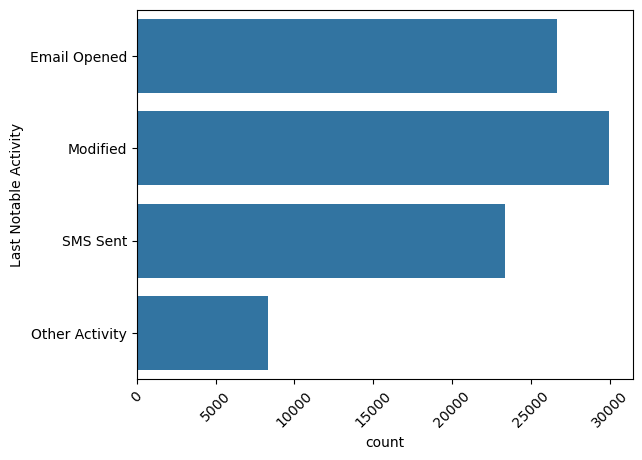

In [509]:
sns.countplot(data_frame_leads['Last Notable Activity'])
plt.xticks(rotation=45)
plt.show()

**11.CITY**

In [510]:
data_frame_leads['City'].unique()

array(['Thane & Outskirts', 'Select', 'Mumbai', 'Other Cities',
       'Other Cities of Maharashtra', 'Tier II Cities',
       'Other Metro Cities'], dtype=object)

In [511]:
data_frame_leads['City'].value_counts()

City
Mumbai                         36397
Select                         25266
Thane & Outskirts               8414
Other Cities                    7841
Other Cities of Maharashtra     5264
Other Metro Cities              4227
Tier II Cities                   875
Name: count, dtype: int64

In [512]:
# value - Mumbai
data_frame_leads['City'] = data_frame_leads['City'].fillna("Mumbai")

In [513]:
data_frame_leads['City'].value_counts()

City
Mumbai                         36397
Select                         25266
Thane & Outskirts               8414
Other Cities                    7841
Other Cities of Maharashtra     5264
Other Metro Cities              4227
Tier II Cities                   875
Name: count, dtype: int64

In [514]:
#Revisando el porcentaje de distribucion
data_frame_leads['City'].value_counts()*100/data_frame_leads.shape[0]

City
Mumbai                         41.227176
Select                         28.619002
Thane & Outskirts               9.530606
Other Cities                    8.881564
Other Cities of Maharashtra     5.962575
Other Metro Cities              4.787957
Tier II Cities                  0.991120
Name: count, dtype: float64

**REVISAR LOS VALORES NUMERICOS DE CADA DIMENSION**

**1.LEAD NUMBER**

count     88284.00000
mean     549279.18750
std      260446.15625
min      100002.00000
25%      322655.25000
50%      549481.00000
75%      775599.50000
max      999996.00000
Name: Lead Number, dtype: float64

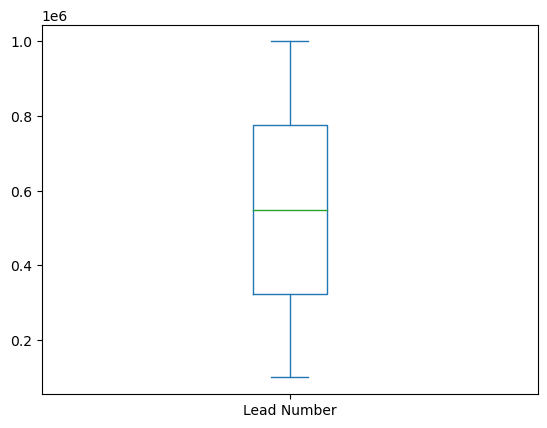

In [515]:
converted = pd.to_numeric(data_frame_leads["Lead Number"],downcast='float',errors='coerce')
converted.plot(kind='box')
converted.describe()
#Tiene sentido porque es un identificador para el lead

**2.Total Visits**

count    88284.000000
mean         2.119795
std          1.716035
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: TotalVisits, dtype: float64

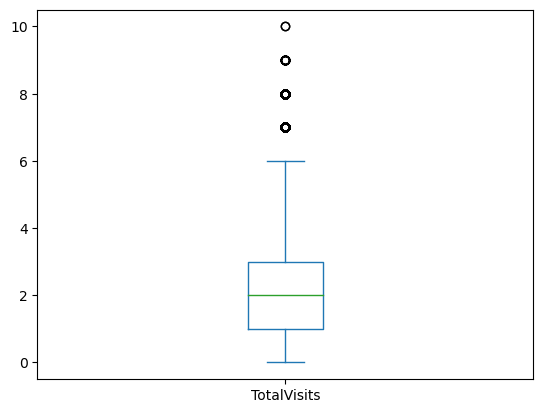

In [516]:
converted =pd.to_numeric(data_frame_leads["TotalVisits"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()

**3. Page Views Per Visit**

count    88284.000000
mean         1.510998
std          1.557528
min          0.000000
25%          0.270000
50%          0.890000
75%          2.340000
max          6.000000
Name: Page Views Per Visit, dtype: float64

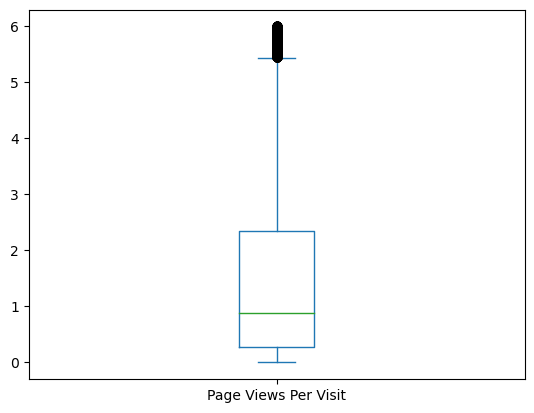

In [517]:
converted =pd.to_numeric(data_frame_leads["Page Views Per Visit"],downcast='float',errors='coerce') # error coerce sirve para que te solicione errores si el CSV esta mal hecho.
converted.plot(kind='box')
converted.describe()


**4.Total Time Spent on Website**

In [518]:
data_frame_leads['Total Time Spent on Website'].describe()

count    88284.000000
mean       278.191337
std        385.326154
min          1.000000
25%         10.000000
50%         86.000000
75%        412.250000
max       2143.000000
Name: Total Time Spent on Website, dtype: float64

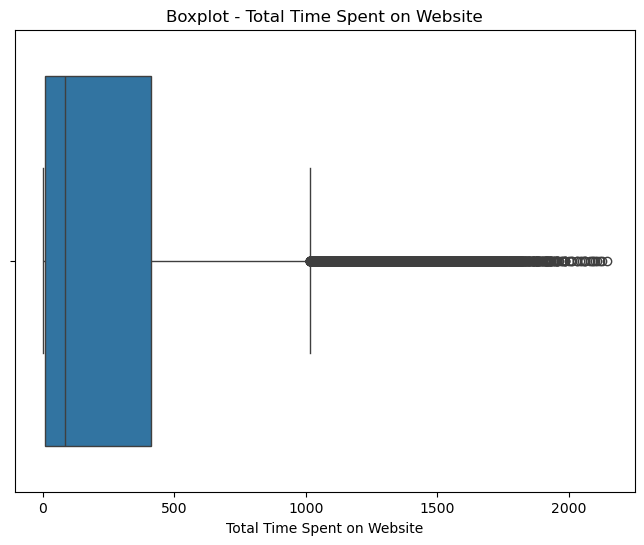

In [519]:
# Asegurar que no haya valores infinitos
data_frame_leads.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar valores nulos si los hay (Esto lo mantenemos para evitar errores en la visualización)
data_frame_leads.dropna(subset=['Total Time Spent on Website'], inplace=True)

# Visualización inicial con boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x=data_frame_leads['Total Time Spent on Website'])
plt.title('Boxplot - Total Time Spent on Website')
plt.show()

# Comentado: Análisis estadístico de outliers
# desc_stats = data_frame_leads['Total Time Spent on Website'].describe()
# Q1 = desc_stats['25%']
# Q3 = desc_stats['75%']
# IQR = Q3 - Q1  # Rango intercuartílico
# limite_inferior = Q1 - 1.5 * IQR
# limite_superior = Q3 + 1.5 * IQR

# print(f"Límite inferior: {limite_inferior}")
# print(f"Límite superior: {limite_superior}")

# outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] > limite_superior) |
#                             (data_frame_leads['Total Time Spent on Website'] < limite_inferior)]
# print(f"Número de outliers detectados: {len(outliers)}")

# Método 1: Eliminar outliers (Comentado)
# data_frame_sin_outliers = data_frame_leads[(data_frame_leads['Total Time Spent on Website'] <= limite_superior) &
#                                            (data_frame_leads['Total Time Spent on Website'] >= limite_inferior)]

# Método 2: Limitar outliers (Comentado)
# data_frame_winsorized = data_frame_leads.copy()
# data_frame_winsorized['Total Time Spent on Website'] = np.where(
#     data_frame_winsorized['Total Time Spent on Website'] > limite_superior,
#     limite_superior,
#     np.where(
#         data_frame_winsorized['Total Time Spent on Website'] < limite_inferior,
#         limite_inferior,
#         data_frame_winsorized['Total Time Spent on Website']
#     )
# )


**Explicaciones de porque se va a trabajar con outliners**
Los modelos de ML de Random Forest y XGboost no son sensibles a los datos fuera de lo común además estos datos pueden dar luz al modelo para entender cuando un usuario (lead) va a hacer una conversion, fijandose en la cantidad de tiempo que pasa en la web.

## EDA -> ANALISIS EXPLORATORIO DE DATOS ##

**UNIVARIATE ANALYSIS**

**1. Variables Categóricas**

In [520]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview       bool
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
rn                                          int64
total_conversions                           int64
total_no_conversions                        int64
dtype: object

In [521]:
#Decido pasar el bool a object para mejorar la calidad del dato y comprension
# Convertir booleano a object
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(str)


In [522]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview     object
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
rn                                          int64
total_conversions                           int64
total_no_conversions                        int64
dtype: object

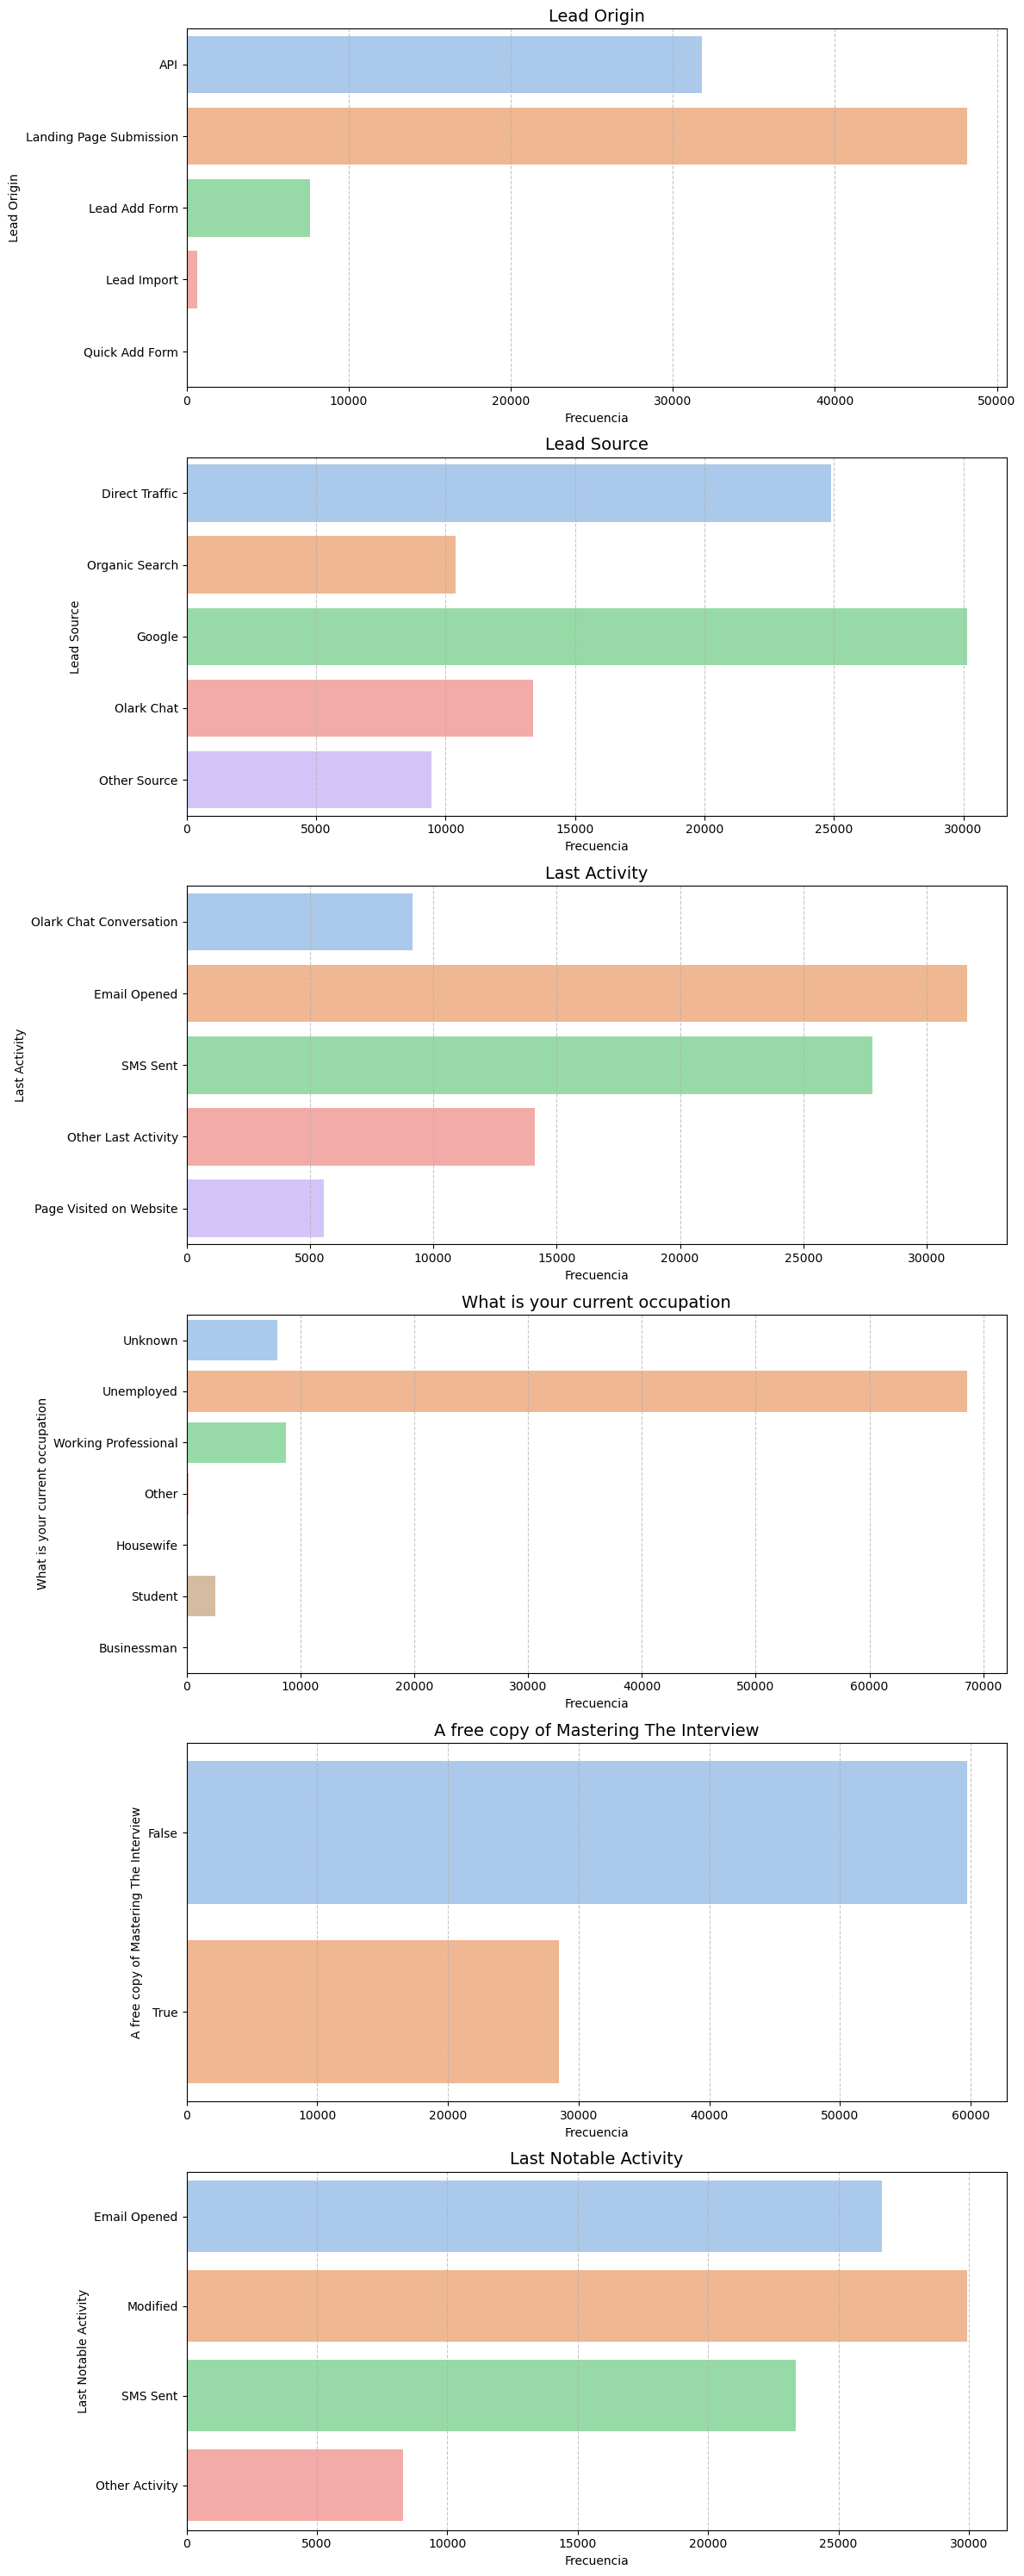

In [523]:
plt.figure(figsize=(12, 30))  # Ajustamos el tamaño para una disposición vertical

columns = [
    'Lead Origin',
    'Lead Source',
    'Last Activity',
    'What is your current occupation',
    'A free copy of Mastering The Interview',
    'Last Notable Activity'
]

# Generar gráficos verticales
for i, column in enumerate(columns, 1):
    plt.subplot(len(columns), 1, i)  # 1 columna, tantas filas como gráficas
    
    # Calcular colores basados en categorías únicas
    num_classes = data_frame_leads[column].nunique()  # Número de categorías únicas
    colors = sns.color_palette('pastel', n_colors=num_classes)  # Generar colores exactos
    
    sns.countplot(y=data_frame_leads[column], hue=data_frame_leads[column], palette=colors, legend=False)
    
    plt.title(column, fontsize=14)
    plt.xlabel('Frecuencia')  # Etiqueta del eje X
    plt.ylabel(column)  # Etiqueta del eje Y
    plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Observaciones del Análisis Exploratorio de Datos (EDA)

## 1. Lead Origin (Origen del Lead)
- **Observación Principal**: La mayoría de los leads provienen de "Landing Page Submission" y "API".  
- **Interpretación**:  
  - Las **páginas de aterrizaje** parecen ser la principal fuente de generación de leads.  
  - La API también es una fuente importante, lo que sugiere automatización o integración con otros sistemas.  
  - **Lead Add Form** y **Lead Import** tienen una contribución menor, lo que puede indicar que son canales menos efectivos o utilizados.

---

## 2. Lead Source (Fuente del Lead)
- **Observación Principal**: "Google" y "Direct Traffic" dominan como fuentes principales de leads.  
- **Interpretación**:  
  - El tráfico orgánico y directo representan la mayor parte de los leads.  
  - "Olark Chat" también tiene una presencia significativa, lo que sugiere que la interacción en vivo puede ser clave en la captación de leads.  
  - **Fuentes menos comunes** podrían representar nichos o esfuerzos de marketing menos efectivos.

---

## 3. Last Activity (Última Actividad)
- **Observación Principal**: "Email Opened" y "SMS Sent" son las actividades más frecuentes.  
- **Interpretación**:  
  - Los leads parecen responder más a correos electrónicos y mensajes SMS, lo que indica que estos canales son efectivos.  
  - Actividades como "Page Visited on Website" tienen menos frecuencia, pero siguen siendo relevantes.

---

## 4. What is your Current Occupation (Ocupación Actual)
- **Observación Principal**:  
  - La mayoría de los leads están **desempleados** o tienen un estado **desconocido**.  
  - "Working Professional" también representa una parte considerable.  
- **Interpretación**:  
  - El alto número de desempleados puede indicar que el producto o servicio se dirige a personas que buscan mejorar sus habilidades o encontrar trabajo.  
  - La categoría **"Unknown"** debería investigarse más a fondo, ya que podría haber falta de información relevante que afecte el análisis.

---

## 5. A Free Copy of Mastering The Interview (Copia Gratuita de "Mastering The Interview")
- **Observación Principal**:  
  - La mayoría de los leads **no** solicitan una copia gratuita.  
- **Interpretación**:  
  - Puede que el recurso no sea atractivo o no se promocione correctamente.  
  - La conversión en aquellos que sí solicitan la copia es notablemente mayor, lo que indica que este grupo tiene más interés.

---

## 6. Last Notable Activity (Última Actividad Notable)
- **Observación Principal**:  
  - Las actividades más comunes son "Email Opened" y "Modified".  
- **Interpretación**:  
  - El seguimiento por correo electrónico sigue siendo un canal crucial.  
  - La actividad **"Modified"** puede reflejar leads que han actualizado información o interactuado recientemente con la plataforma.

---

## Reflexión Final
- **Los valores "Unknown"** están presentes en varias variables (especialmente en **Occupación** y **Ciudad**).  
- Es importante evaluar si estos valores deben ser tratados (imputación) o si pueden mantenerse, ya que el modelo debe reflejar datos del mundo real, donde no siempre se tiene toda la información.  


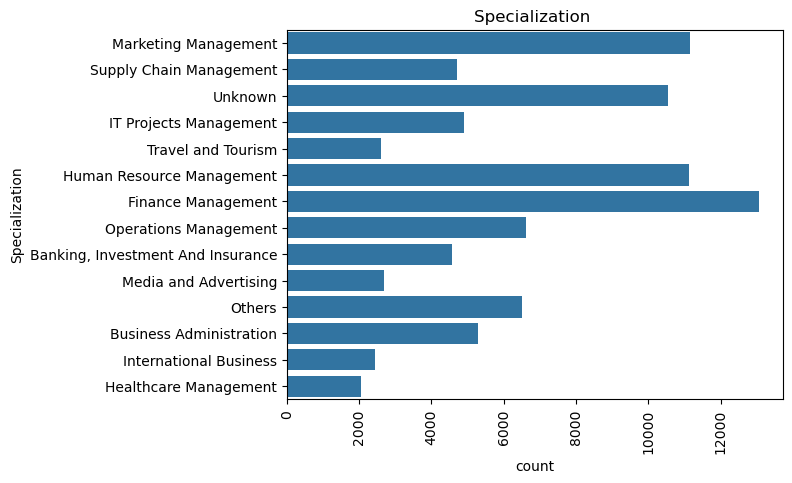

In [524]:
sns.countplot(data_frame_leads['Specialization'])
plt.title('Specialization ')
plt.xticks(rotation=90)
plt.show()

# Observaciones: Especialización

## Especialización (Specialization)
- **Observación Clave**:  
  - La mayoría de los leads tienen una especialización **desconocida (Unknown)**.  
  - Las especializaciones más comunes después de "Unknown" son **Finance Management** y **Human Resource Management**.  
- **Interpretación**:  
  - Es posible que muchos leads no completen este campo, lo que sugiere una brecha en la recopilación de datos.  
  - Las áreas de **gestión financiera y de recursos humanos** parecen atraer la mayor atención.  

- **Recomendación**:  
  - Considerar estrategias para incentivar a los usuarios a completar esta información, ya que puede ser valiosa para la segmentación de leads.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_11808\3936043565.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")


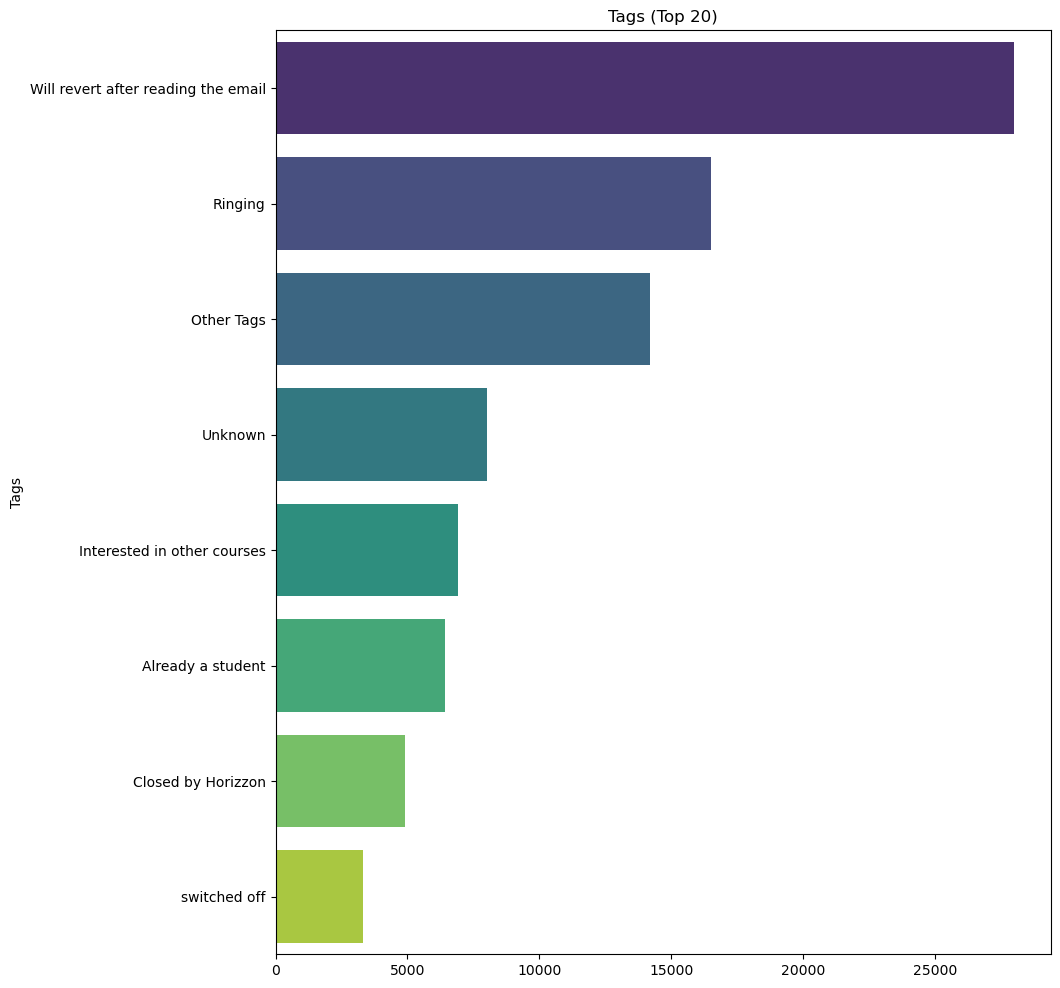

In [525]:
data_sample = data_frame_leads.sample(10000)  # 10,000 filas aleatorias

plt.figure(figsize=(10, 12))

tags_counts = data_frame_leads['Tags'].value_counts().nlargest(20)  # Top 20 Tags
sns.barplot(x=tags_counts.values, y=tags_counts.index, palette="viridis")
plt.title('Tags (Top 20)')
plt.show()


# Observaciones: Tags

## Tags (Top 20)
- **Observación Clave**:  
  - El tag más frecuente es **"Unknown"**, lo que representa una gran parte de los datos.  
  - Tags relevantes como **"Will revert after reading the email"** y **"Other Tags"** también destacan, pero con una frecuencia significativamente menor.  
- **Interpretación**:  
  - La alta proporción de "Unknown" puede indicar que muchos leads no están etiquetados adecuadamente o el proceso de seguimiento es incompleto.  
  - La categoría **"Will revert after reading the email"** sugiere que una porción de los leads necesita más tiempo antes de tomar decisiones.  

- **Recomendación**:  
  - Es necesario **mejorar la recolección de datos y reducir la cantidad de "Unknown"** a través de un etiquetado más riguroso y procesos de seguimiento más efectivos.  


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_11808\2747208311.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")


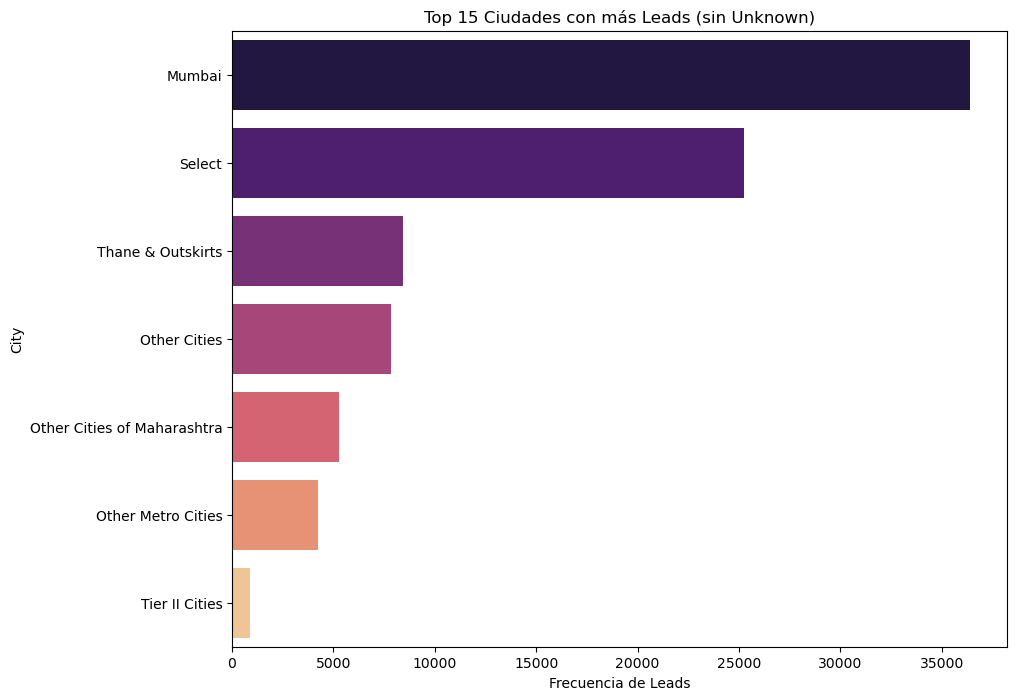

In [526]:

# Filtrar 'Unknown' del dataframe
filtered_data = data_frame_leads[data_frame_leads['City'] != 'Unknown']

# Agrupar por ciudad y contar ocurrencias
city_counts = filtered_data['City'].value_counts()

# Mostrar las 15 ciudades con más leads
top_cities = city_counts.nlargest(15)

# Crear el gráfico (horizontal para mayor claridad)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_cities.values, y=top_cities.index, palette="magma")

# Añadir etiquetas y título
plt.title('Top 15 Ciudades con más Leads (sin Unknown)')
plt.xlabel('Frecuencia de Leads')
plt.ylabel('City')

plt.show()



# Observaciones: Ciudades con más Leads (sin Unknown)

## Top 15 Ciudades con más Leads
- **Observación Clave**:  
  - La ciudad con mayor cantidad de leads es **South Michael**, seguida por **East Michael** y **Port Michael**.  
  - La distribución muestra una clara concentración de leads en estas tres ciudades, lo que podría indicar una mayor demanda o presencia de mercado en esas áreas.  

- **Interpretación**:  
  - La eliminación de la categoría **"Unknown"** permite obtener una visión más precisa de las ciudades con mayor actividad de leads.  
  - La dispersión de leads en diferentes ciudades también sugiere la necesidad de estrategias locales para maximizar conversiones.  


**Variables Numericas**

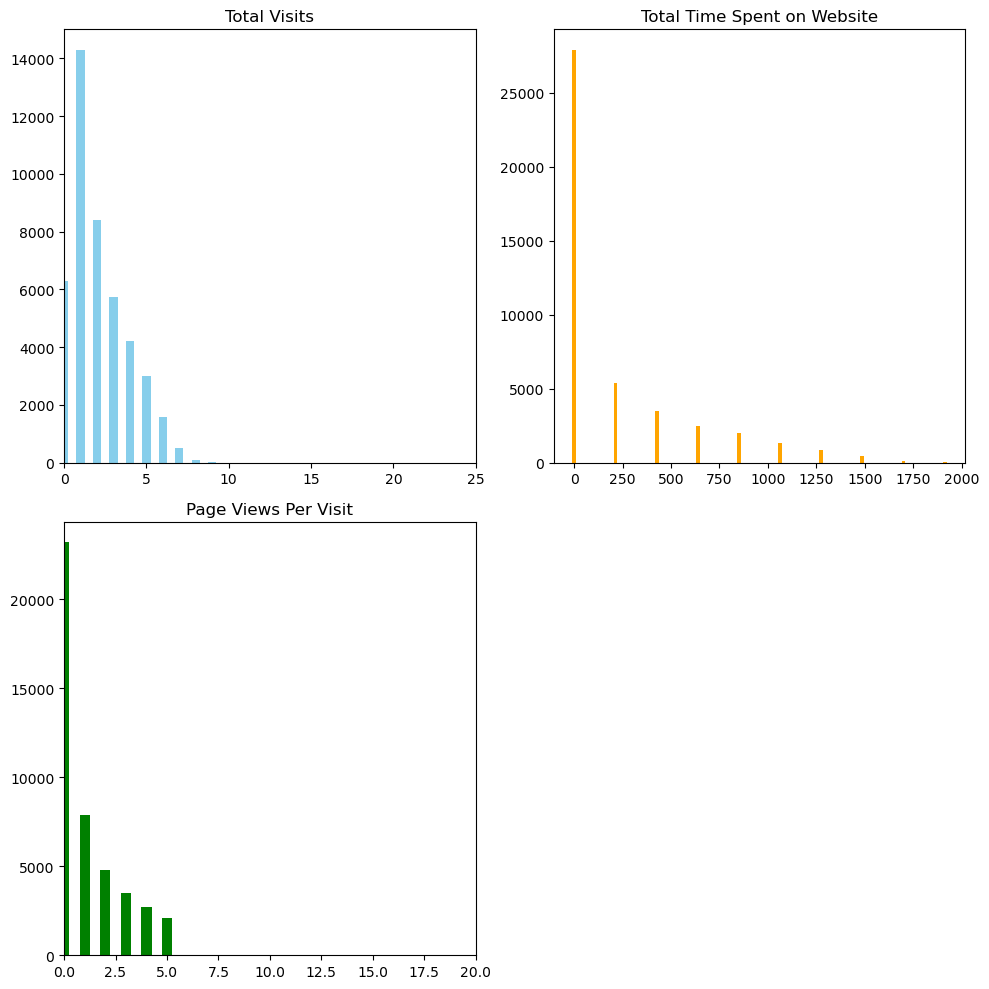

In [527]:

# Muestra aleatoria (50% del dataset o 50k filas)
sample_data = data_frame_leads.sample(frac=0.5, random_state=42)

plt.figure(figsize=(10, 10))

# Histograma para 'Total Visits'
plt.subplot(221)
hist_visits, bins_visits = np.histogram(sample_data['TotalVisits'], bins=50, range=(0, 25))
plt.bar(bins_visits[:-1], hist_visits, width=0.5, color='skyblue')
plt.title('Total Visits')
plt.xlim(0, 25)

# Histograma para 'Total Time Spent on Website'
plt.subplot(222)
hist_time, bins_time = np.histogram(sample_data['Total Time Spent on Website'], bins=10)
plt.bar(bins_time[:-1], hist_time, width=20, color='orange')
plt.title('Total Time Spent on Website')

# Histograma para 'Page Views Per Visit'
plt.subplot(223)
hist_pageviews, bins_pageviews = np.histogram(sample_data['Page Views Per Visit'], bins=20, range=(0, 20))
plt.bar(bins_pageviews[:-1], hist_pageviews, width=0.5, color='green')
plt.title('Page Views Per Visit')
plt.xlim(0, 20)

plt.tight_layout()
plt.show()


# Observación: Análisis de Visitas y Tiempo en la Web

## Distribución de Total Visits, Total Time Spent on Website y Page Views Per Visit
- **Total Visits**: La mayoría de los leads realizaron entre **1 y 5 visitas**, con una fuerte caída en visitas superiores a este rango. Esto sugiere que la mayoría de los usuarios no regresan repetidamente al sitio.  
- **Total Time Spent on Website**: Se observa una distribución sesgada a la izquierda, donde la mayoría de los usuarios pasan menos de **250 segundos** en el sitio. Este comportamiento podría indicar que los usuarios encuentran rápidamente lo que buscan o abandonan la web tras una breve navegación.  
- **Page Views Per Visit**: La mayoría de los leads realizan entre **1 y 3 vistas** por visita. Esta tendencia refuerza la idea de que los usuarios no navegan profundamente en el sitio durante sus visitas.  


**Bivariate Analysis**

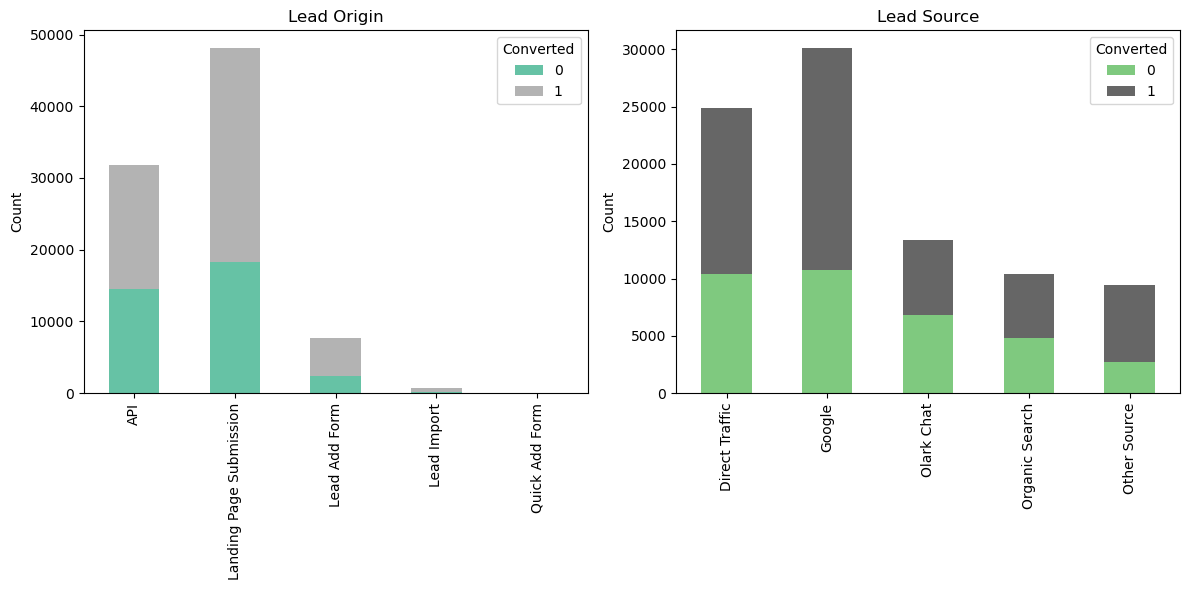

In [528]:

# Muestreo opcional para grandes datasets (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)  
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Precalcular los valores para las gráficas
lead_origin_counts = pd.crosstab(data_sample['Lead Origin'], data_sample['Converted'])
lead_source_counts = pd.crosstab(data_sample['Lead Source'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Lead Origin
plt.subplot(1, 2, 1)
lead_origin_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set2')
plt.title('Lead Origin')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Lead Source
plt.subplot(1, 2, 2)
lead_source_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Accent')
plt.title('Lead Source')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Análisis de Origen y Fuente de Leads

## Lead Origin y Lead Source
- **Lead Origin**: La mayoría de los leads provienen de **Landing Page Submission** y **API**, destacando la importancia de estos canales en la captación de leads. Sin embargo, hay una alta proporción de leads no convertidos en ambos orígenes, lo que sugiere la necesidad de optimizar la conversión en estos puntos.  
- **Lead Source**: **Google** y **Direct Traffic** representan las principales fuentes de tráfico. A pesar de tener un número significativo de conversiones, también hay una gran cantidad de leads no convertidos. El tráfico de **Olark Chat** y **Organic Search** muestra tasas de conversión moderadas, lo que indica que estos canales podrían necesitar una estrategia de engagement más efectiva.  

**Conclusión**: La optimización de las páginas de destino y una mejor segmentación del tráfico directo y de Google podrían mejorar significativamente las tasas de conversión.  


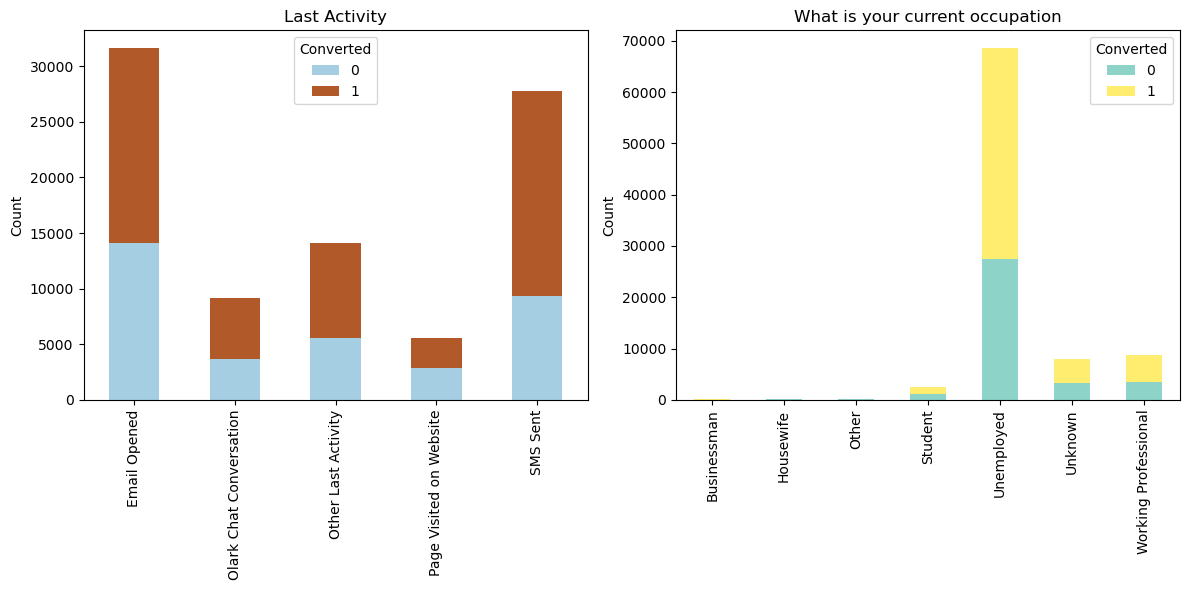

In [529]:
# Muestreo opcional para mejorar rendimiento (descomentar si es necesario)
# data_sample = data_frame_leads.sample(frac=0.5, random_state=42)
data_sample = data_frame_leads  # Usamos el dataset completo si no hay problemas de rendimiento

# Pre-calcular valores para las gráficas
activity_counts = pd.crosstab(data_sample['Last Activity'], data_sample['Converted'])
occupation_counts = pd.crosstab(data_sample['What is your current occupation'], data_sample['Converted'])

# Gráfico
plt.figure(figsize=(12, 6))

# Last Activity
plt.subplot(1, 2, 1)
activity_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Paired')
plt.title('Last Activity')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

# Current Occupation
plt.subplot(1, 2, 2)
occupation_counts.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='Set3')
plt.title('What is your current occupation')
plt.xticks(rotation=90)
plt.xlabel('')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


# Observación: Actividad Final e Información Ocupacional

## Last Activity y Current Occupation
- **Last Activity**: La apertura de correos electrónicos y el envío de SMS son las actividades finales más comunes. Sin embargo, **SMS Sent** tiene una tasa de conversión notablemente más alta que **Email Opened**, lo que sugiere que el envío de SMS podría ser un canal más efectivo para impulsar conversiones. Las actividades como **Olark Chat Conversation** y **Page Visited on Website** muestran tasas de conversión más bajas.  
- **Current Occupation**: La mayoría de los leads provienen de personas desempleadas (**Unemployed**) y de aquellos cuya ocupación es desconocida (**Unknown**). Los leads con ocupación desconocida también presentan una tasa de conversión significativa, lo que sugiere que este grupo no debe ser subestimado a pesar de la falta de información detallada.  

**Conclusión**: Las estrategias de marketing deberían enfocarse en maximizar el impacto de los SMS y mejorar el engagement con leads desempleados, así como explorar formas de segmentar mejor a aquellos con ocupación desconocida.  


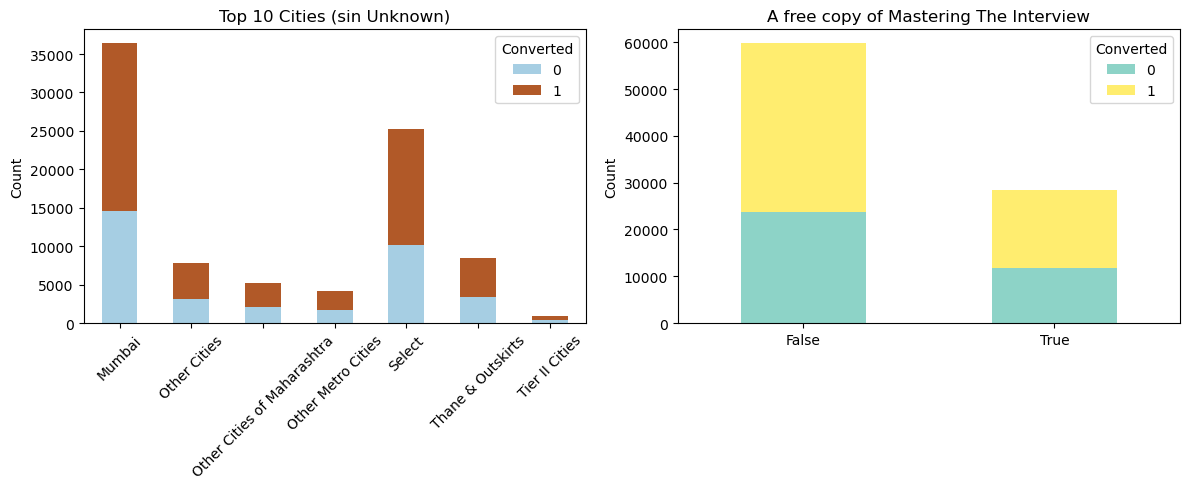

In [530]:
# Filtrar ciudades que no sean 'Unknown'
data_sample_filtered = data_sample[data_sample['City'] != 'Unknown']

# Calcular top 10 ciudades sin 'Unknown'
top_cities_filtered = data_sample_filtered['City'].value_counts().nlargest(10).index
city_counts_filtered = data_sample_filtered[data_sample_filtered['City'].isin(top_cities_filtered)] \
                        .groupby(['City', 'Converted']).size().unstack(fill_value=0)

# Calcular conteo de 'A free copy of Mastering The Interview' frente a conversiones
copy_counts = pd.crosstab(data_sample['A free copy of Mastering The Interview'], data_sample['Converted'])

# Gráfico optimizado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# City sin 'Unknown'
city_counts_filtered.plot(kind='bar', stacked=True, ax=axes[0], colormap='Paired')
axes[0].set_title('Top 10 Cities (sin Unknown)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('')
axes[0].set_ylabel('Count')

# A free copy of Mastering The Interview
copy_counts.plot(kind='bar', stacked=True, ax=axes[1], colormap='Set3')
axes[1].set_title('A free copy of Mastering The Interview')
axes[1].tick_params(axis='x', rotation=0)
axes[1].set_xlabel('')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()



** VVEREMOS SI HAY QUE MODIFICAR ALGO **

Text(0.5, 1.0, 'Last Notable Activity')

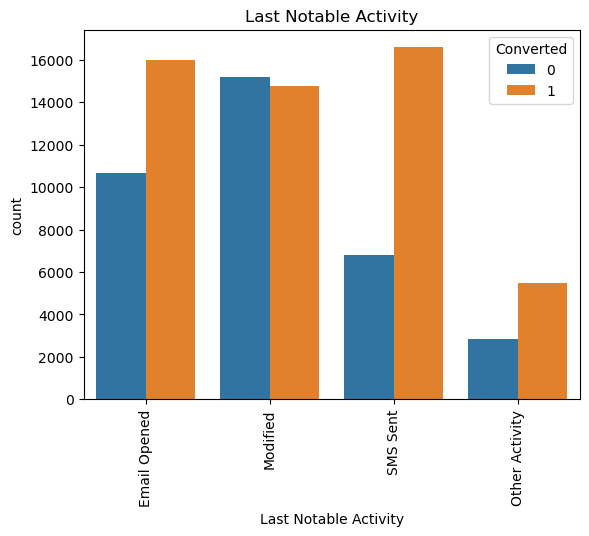

In [531]:
sns.countplot(x='Last Notable Activity', hue='Converted', data= data_frame_leads).tick_params(axis='x', rotation = 90)
plt.title('Last Notable Activity')

### Observación:
El gráfico muestra la actividad notable más reciente de los leads y su relación con la conversión. Se observa que las actividades **"Modified"** y **"Email Opened"** son las más comunes, pero presentan una menor tasa de conversión en comparación con otras. **"SMS Sent"** destaca por tener una distribución más equilibrada entre convertidos y no convertidos, lo que podría indicar que este tipo de actividad genera un mayor nivel de interés o engagement. Por otro lado, **"Other Activity"** tiene una baja frecuencia general, lo que podría sugerir que los leads con actividades menos relevantes o específicas tienden a tener menores tasas de conversión.


C:\Users\DYLAN\AppData\Local\Temp\ipykernel_11808\1525600889.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')


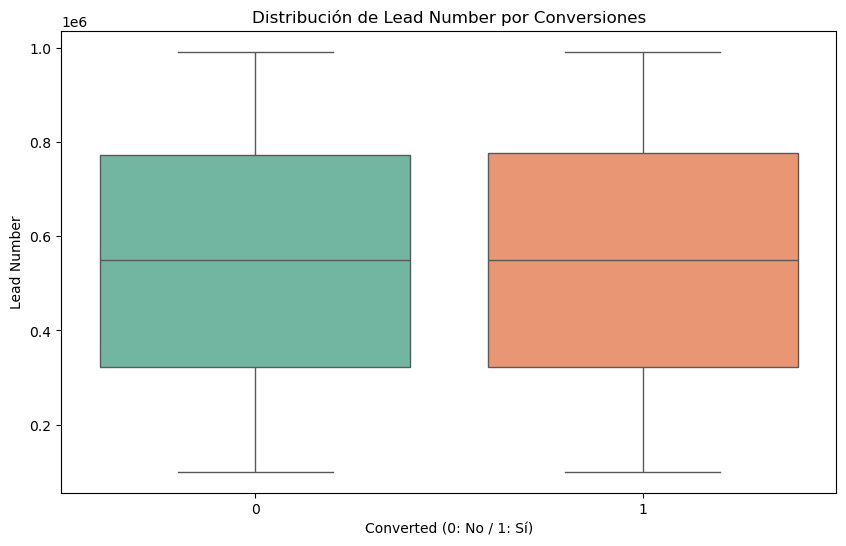

In [532]:

# Muestreo opcional (reducir si el dataset es muy grande)
data_sample = data_frame_leads.sample(frac=0.6, random_state=42)  # Toma el 60% del dataset

# Limitar el rango de Lead Number para evitar outliers extremos visuales
data_sample['Lead Number'] = data_sample['Lead Number'].clip(upper=data_sample['Lead Number'].quantile(0.99))

# Graficar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_sample, x='Converted', y='Lead Number', palette='Set2')

plt.title('Distribución de Lead Number por Conversiones')
plt.ylabel('Lead Number')
plt.xlabel('Converted (0: No / 1: Sí)')
plt.show()


### Observación:
El boxplot muestra la distribución del número de lead en función de si estos se convirtieron (1) o no (0). Se observa que las distribuciones son muy similares en ambas categorías, lo que sugiere que **el número de lead no tiene un impacto significativo en la conversión**. Los valores atípicos (outliers) están presentes en ambos grupos, pero no parece haber una diferencia notable en las medianas ni en el rango intercuartílico (IQR). Esta gráfica indica que probablemente el número de lead **no es un predictor relevante** para determinar la probabilidad de conversión.


**Observación**


## DATA PREPARATION ##

**Convertir el tipo de datos de alguna variables (YES/NO) a 0/1**

In [533]:
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].map({'True': True, 'False': False})
data_frame_leads['A free copy of Mastering The Interview'] = data_frame_leads['A free copy of Mastering The Interview'].astype(int)


In [534]:
print(data_frame_leads['A free copy of Mastering The Interview'].value_counts())


A free copy of Mastering The Interview
0    59762
1    28522
Name: count, dtype: int64


In [535]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit,rn,total_conversions,total_no_conversions
0,773419,API,Direct Traffic,1,39,0.26,Olark Chat Conversation,Unknown,0,Ringing,Thane & Outskirts,Email Opened,0.0,Marketing Management,100.895493,520,68545,101958
1,117972,API,Organic Search,1,1,0.03,Email Opened,Unemployed,0,Ringing,Select,Modified,0.0,Supply Chain Management,100.895493,28880,68545,101958
2,742831,Landing Page Submission,Google,0,1,0.06,Email Opened,Unemployed,0,Unknown,Select,Modified,0.0,Unknown,100.895493,33594,68545,101958
3,671011,Landing Page Submission,Direct Traffic,1,33,0.14,Email Opened,Working Professional,0,Will revert after reading the email,Mumbai,Email Opened,0.0,IT Projects Management,100.895493,60914,68545,101958
4,284718,Lead Add Form,Google,0,4,0.23,SMS Sent,Unknown,0,Ringing,Select,Modified,0.0,Travel and Tourism,100.895493,21263,68545,101958


In [536]:
data_frame_leads.dtypes

Lead Number                                 int64
Lead Origin                                object
Lead Source                                object
Converted                                   int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
Last Activity                              object
What is your current occupation            object
A free copy of Mastering The Interview      int32
Tags                                       object
City                                       object
Last Notable Activity                      object
TotalVisits                               float64
Specialization                             object
Average Time Per Visit                    float64
rn                                          int64
total_conversions                           int64
total_no_conversions                        int64
dtype: object

**Para las variables categóricas con multiples niveles, se han creado algunos dummy features**

In [537]:
catColumns=['Lead Origin','Lead Source','Last Activity','Specialization','What is your current occupation','Tags','City','Last Notable Activity']
catColumns

#Lead Origin ok
#Lead Source ok
#Las Activity No eliminar
#Specialization  No eliminar nada
#What is your current occupation No eliminar la primera
#No eliminar la primera de last notable activity

['Lead Origin',
 'Lead Source',
 'Last Activity',
 'Specialization',
 'What is your current occupation',
 'Tags',
 'City',
 'Last Notable Activity']

In [538]:
# Lista de columnas categóricas
catColumns = ['Lead Origin', 'Lead Source', 'Last Activity', 'Specialization', 
              'What is your current occupation', 'Tags', 'City', 'Last Notable Activity']

# Crear dummies sin eliminar la primera para todas las columnas
dummies = pd.get_dummies(data_frame_leads[catColumns], drop_first=False).astype(int)

# Eliminar la primera categoría de columnas específicas
for col in catColumns:
    if col in ['Lead Origin', 'Lead Source', 'What is your current occupation']:  # Solo eliminar la primera de estas columnas
        dummies.drop(dummies.filter(like=f'{col}_').columns[0], axis=1, inplace=True)

dummyVariable = dummies
dummyVariable.head()


,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [539]:
dummyVariable.shape

(88284, 52)

In [540]:
# Add the results to the original bike dataframe
data_frame_leads = pd.concat([data_frame_leads,dummyVariable], axis = 1)

In [541]:
data_frame_leads.head()

,Lead Number,Lead Origin,Lead Source,Converted,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,A free copy of Mastering The Interview,Tags,City,Last Notable Activity,TotalVisits,Specialization,Average Time Per Visit,rn,total_conversions,total_no_conversions,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,773419,API,Direct Traffic,1,39,0.26,Olark Chat Conversation,Unknown,0,Ringing,Thane & Outskirts,Email Opened,0.0,Marketing Management,100.895493,520,68545,101958,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,117972,API,Organic Search,1,1,0.03,Email Opened,Unemployed,0,Ringing,Select,Modified,0.0,Supply Chain Management,100.895493,28880,68545,101958,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,742831,Landing Page Submission,Google,0,1,0.06,Email Opened,Unemployed,0,Unknown,Select,Modified,0.0,Unknown,100.895493,33594,68545,101958,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,671011,Landing Page Submission,Direct Traffic,1,33,0.14,Email Opened,Working Professional,0,Will revert after reading the email,Mumbai,Email Opened,0.0,IT Projects Management,100.895493,60914,68545,101958,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,284718,Lead Add Form,Google,0,4,0.23,SMS Sent,Unknown,0,Ringing,Select,Modified,0.0,Travel and Tourism,100.895493,21263,68545,101958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [542]:
data_frame_leads.shape

(88284, 70)

**Decisión de eliminar las columnas**

In [543]:
# Drop columns for which we have created the dummies
data_frame_leads.drop(catColumns, axis = 1, inplace = True)

In [544]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,rn,total_conversions,total_no_conversions,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,773419,1,39,0.26,0,0.0,100.895493,520,68545,101958,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,117972,1,1,0.03,0,0.0,100.895493,28880,68545,101958,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,742831,0,1,0.06,0,0.0,100.895493,33594,68545,101958,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,671011,1,33,0.14,0,0.0,100.895493,60914,68545,101958,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,284718,0,4,0.23,0,0.0,100.895493,21263,68545,101958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [545]:
data_frame_leads.shape

(88284, 62)

In [546]:
data_frame_leads.head()

,Lead Number,Converted,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,rn,total_conversions,total_no_conversions,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,773419,1,39,0.26,0,0.0,100.895493,520,68545,101958,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,117972,1,1,0.03,0,0.0,100.895493,28880,68545,101958,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,742831,0,1,0.06,0,0.0,100.895493,33594,68545,101958,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,671011,1,33,0.14,0,0.0,100.895493,60914,68545,101958,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,284718,0,4,0.23,0,0.0,100.895493,21263,68545,101958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


**TRAIN - TEST SPLIT**

In [547]:
#Putting feature variable to X
X = data_frame_leads.drop (['Converted'], axis = 1)
X.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,rn,total_conversions,total_no_conversions,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
0,773419,39,0.26,0,0.0,100.895493,520,68545,101958,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,117972,1,0.03,0,0.0,100.895493,28880,68545,101958,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,742831,1,0.06,0,0.0,100.895493,33594,68545,101958,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
3,671011,33,0.14,0,0.0,100.895493,60914,68545,101958,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
4,284718,4,0.23,0,0.0,100.895493,21263,68545,101958,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [548]:
#Poniendo el response en la variable y
y = data_frame_leads['Converted']
y.head()

0    1
1    1
2    0
3    1
4    0
Name: Converted, dtype: int64

In [549]:
#Splitting the data into train and test
X_train,X_test,y_train, y_test = train_test_split(X,y,train_size=0.7,test_size=0.3,random_state=100)


## SELECCION DE FEATURES ##

In [550]:
X_train.dtypes

Lead Number                                 int64
Total Time Spent on Website                 int64
Page Views Per Visit                      float64
A free copy of Mastering The Interview      int32
TotalVisits                               float64
                                           ...   
City_Tier II Cities                         int32
Last Notable Activity_Email Opened          int32
Last Notable Activity_Modified              int32
Last Notable Activity_Other Activity        int32
Last Notable Activity_SMS Sent              int32
Length: 61, dtype: object

In [551]:
scaler = MinMaxScaler()
X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']] = scaler.fit_transform(X_train[['Lead Number','TotalVisits','Page Views Per Visit','Total Time Spent on Website']])
X_train.head()

,Lead Number,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,TotalVisits,Average Time Per Visit,rn,total_conversions,total_no_conversions,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Other Source,Last Activity_Email Opened,Last Activity_Olark Chat Conversation,Last Activity_Other Last Activity,Last Activity_Page Visited on Website,Last Activity_SMS Sent,"Specialization_Banking, Investment And Insurance",Specialization_Business Administration,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Others,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Unknown,What is your current occupation_Working Professional,Tags_Already a student,Tags_Closed by Horizzon,Tags_Interested in other courses,Tags_Other Tags,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,City_Mumbai,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Select,City_Thane & Outskirts,City_Tier II Cities,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Other Activity,Last Notable Activity_SMS Sent
51866,0.978304,0.143324,0.573333,0,0.3,102.666667,20048,68545,101958,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
110925,0.869505,0.161064,0.310000,0,0.3,115.333333,23191,68545,101958,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
76503,0.012441,0.286181,0.808333,0,0.5,122.800000,49475,68545,101958,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
74276,0.430844,0.034547,0.113333,1,0.1,75.000000,2259,68545,101958,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
31876,0.495158,0.122316,0.131667,0,0.2,131.500000,52289,68545,101958,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [552]:
### Checking the Converted Rate
convertRate = (sum(data_frame_leads['Converted'])/len(data_frame_leads['Converted'].index))*100
convertRate

59.81038466766345

In [553]:
X_train.columns


Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'rn', 'total_conversions', 'total_no_conversions', 'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form', 'Lead Origin_Lead Import', 'Lead Origin_Quick Add Form', 'Lead Source_Google', 'Lead Source_Olark Chat', 'Lead Source_Organic Search', 'Lead Source_Other Source', 'Last Activity_Email Opened', 'Last Activity_Olark Chat Conversation', 'Last Activity_Other Last Activity', 'Last Activity_Page Visited on Website', 'Last Activity_SMS Sent', 'Specialization_Banking, Investment And Insurance', 'Specialization_Business Administration', 'Specialization_Finance Management', 'Specialization_Healthcare Management', 'Specialization_Human Resource Management', 'Specialization_IT Projects Management', 'Specialization_International Business', 'Specialization_Marketing Management', 'Specialization_Media and Advertising',
       

## Observacion de Correlaciones ##


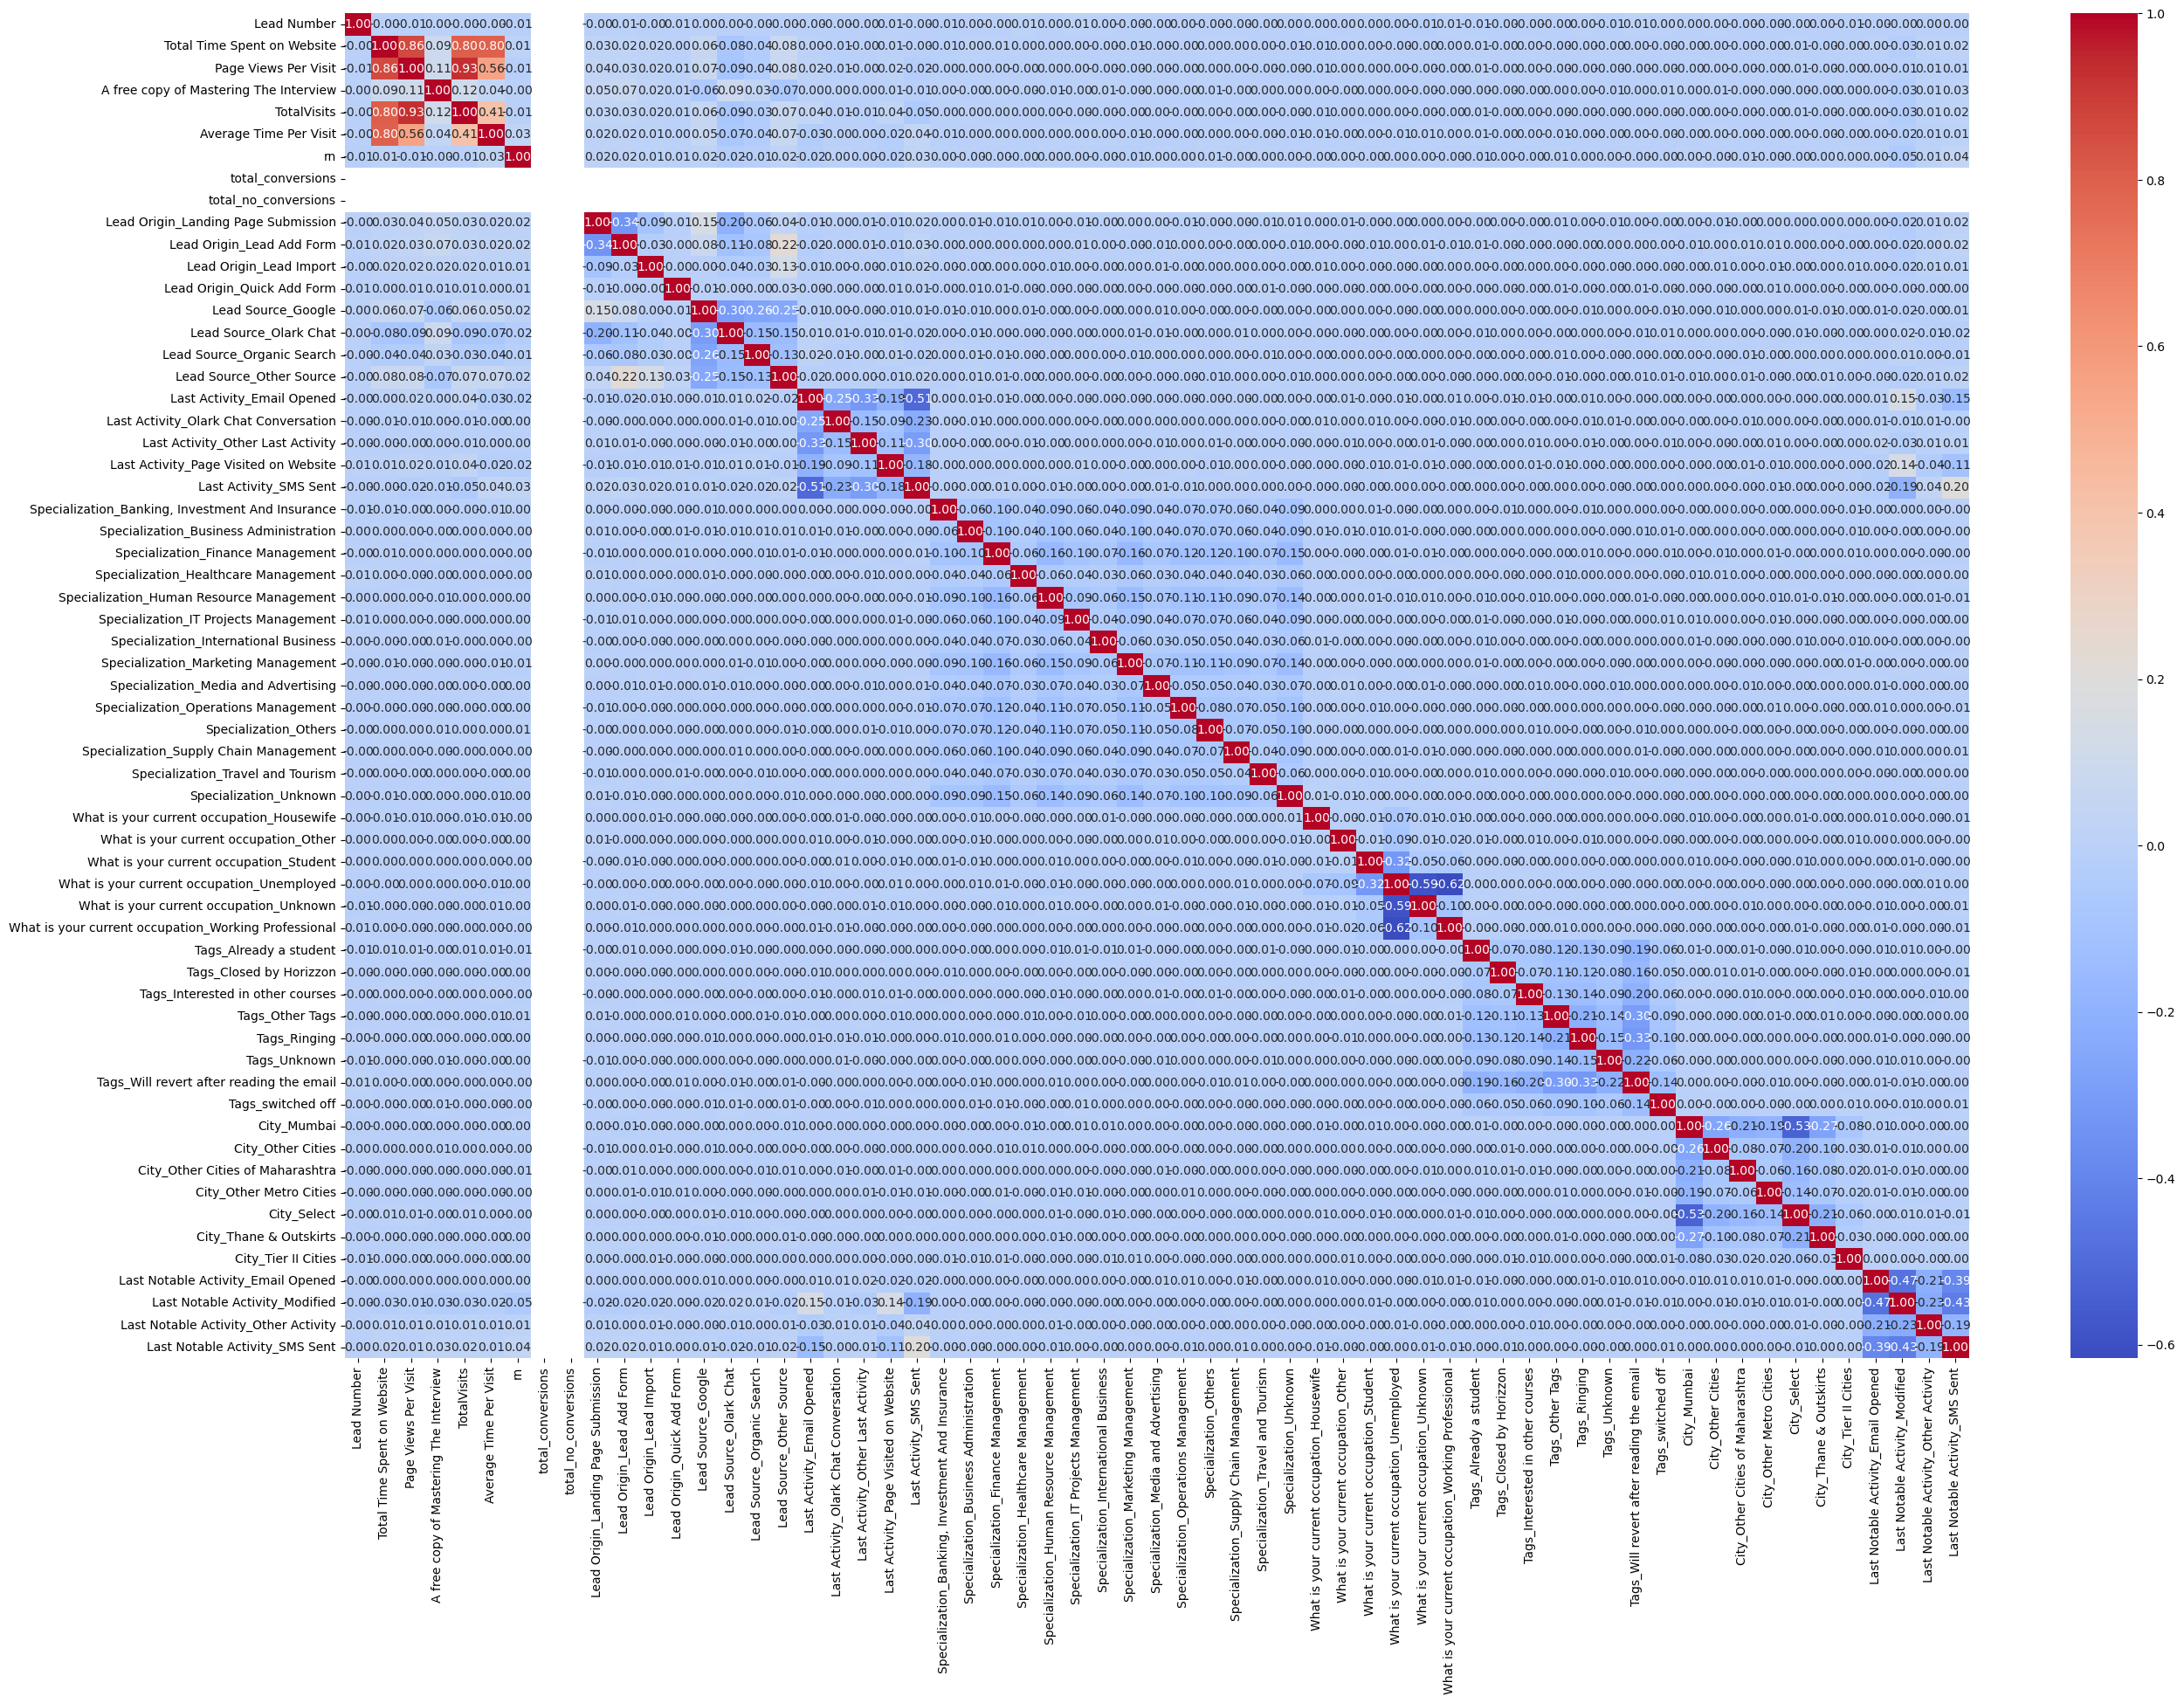

In [554]:
#correlation matrix 
plt.figure(figsize=(30, 20))  # Aumentar tamaño
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()


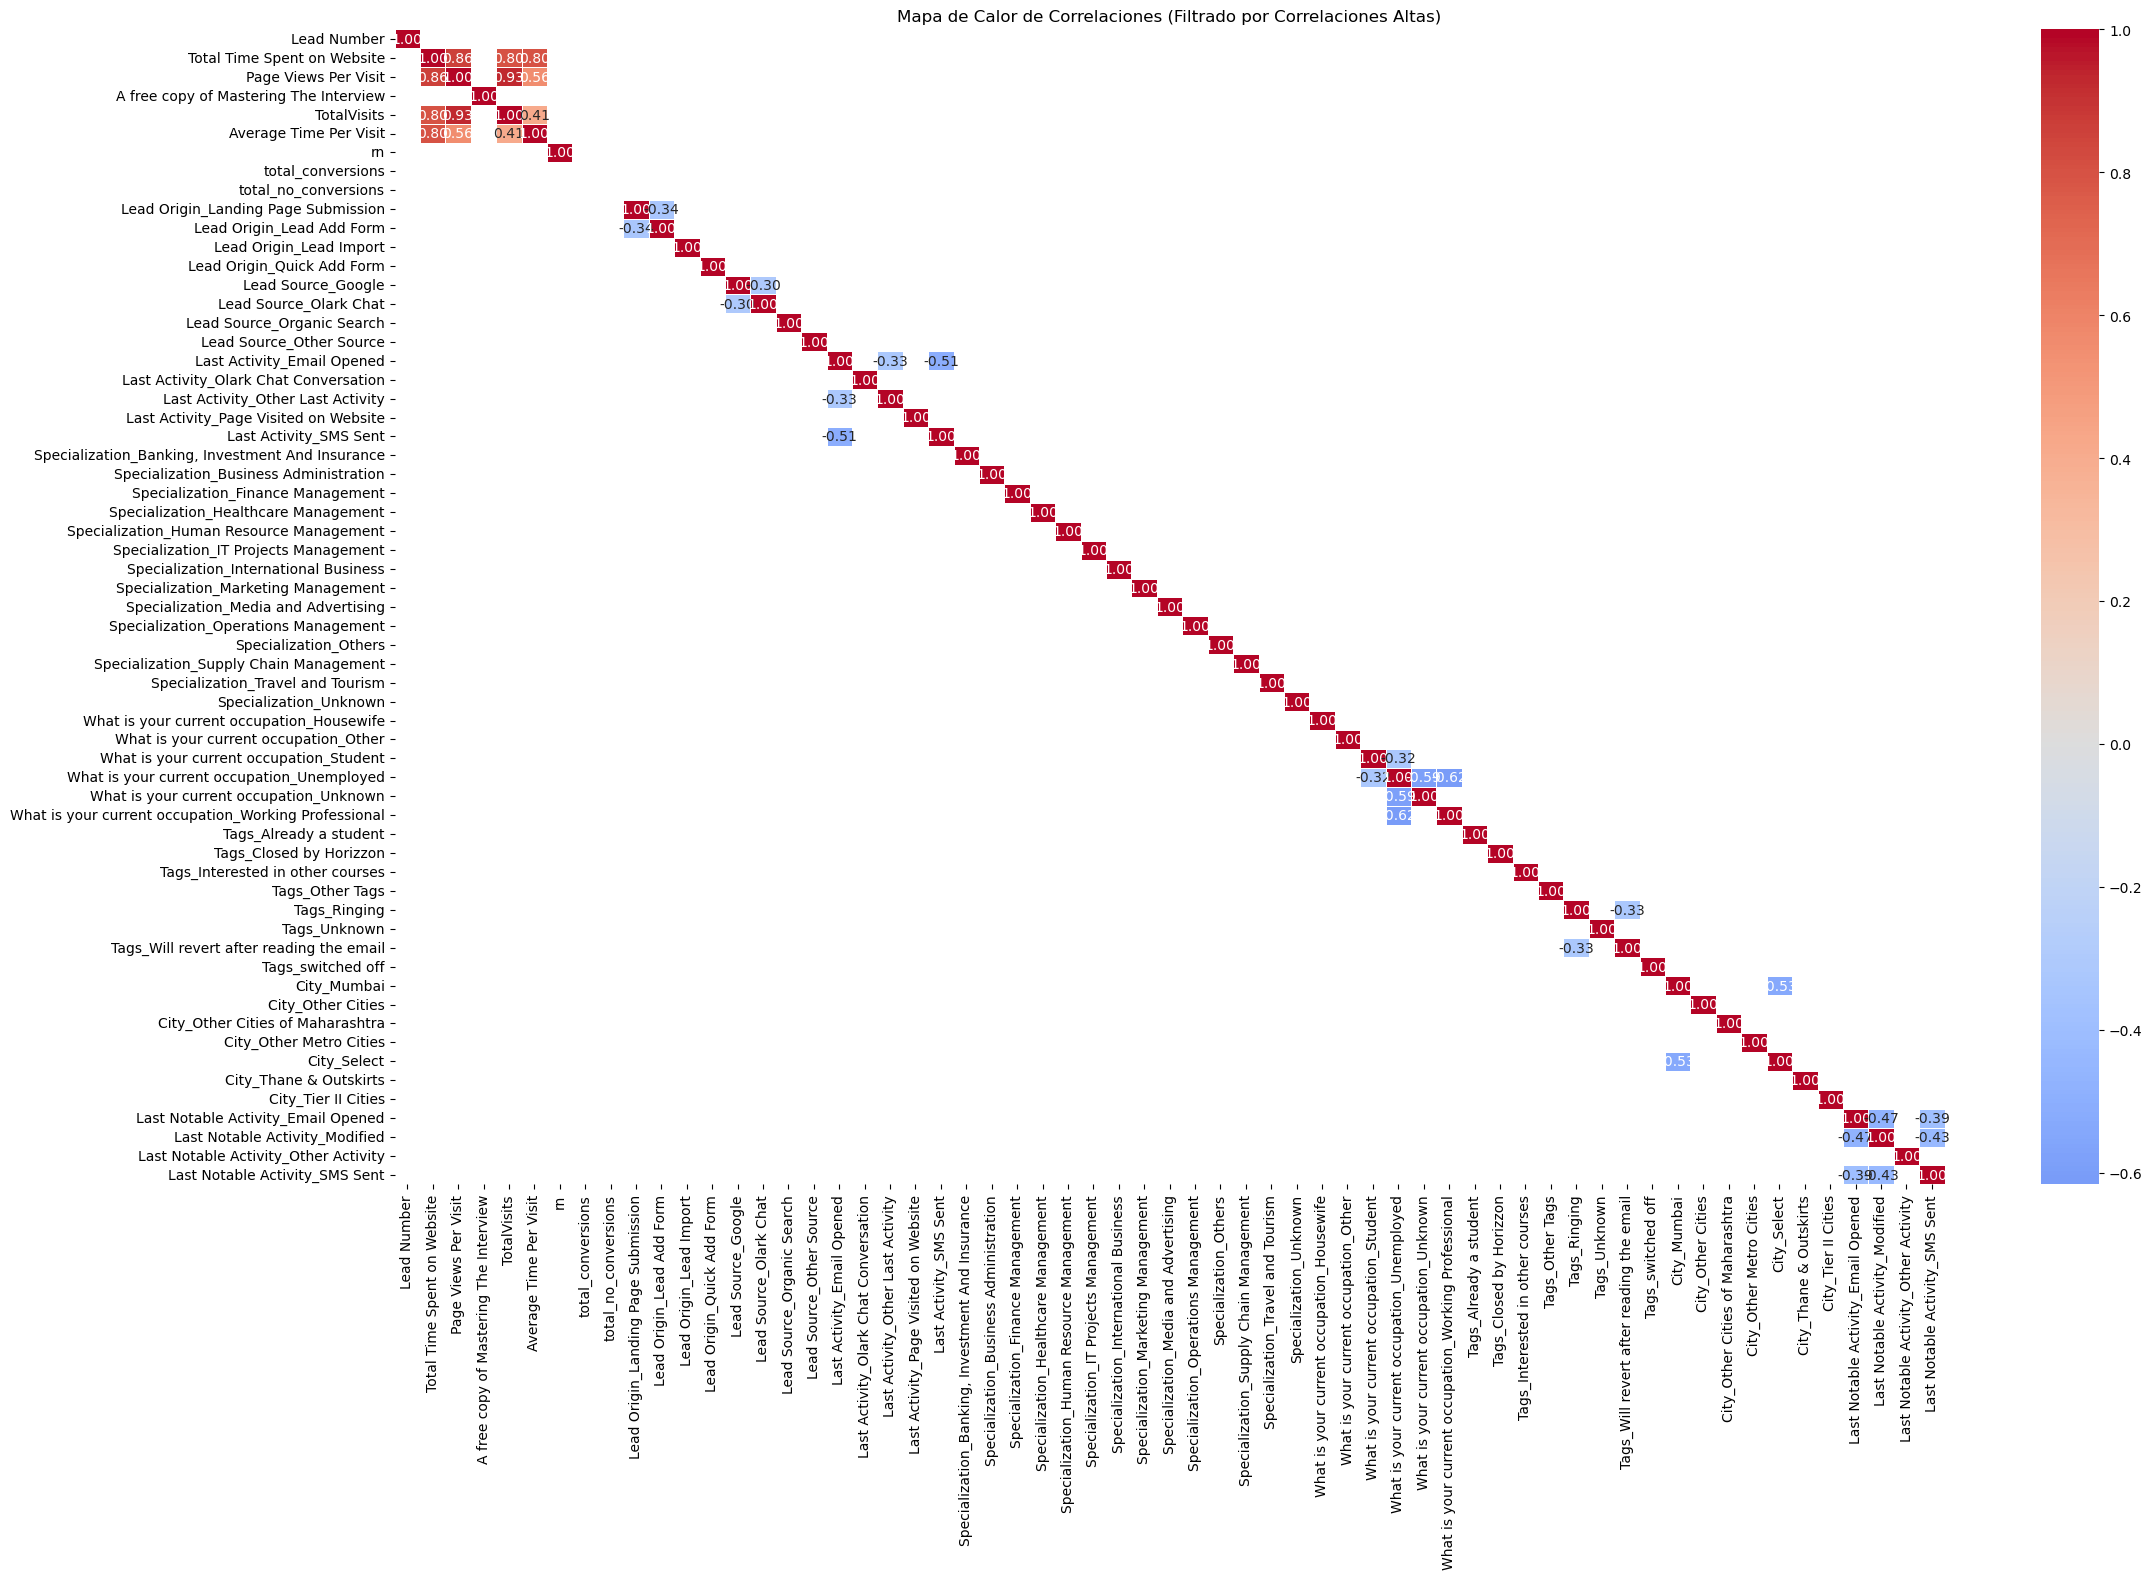

In [555]:
# Calcular la matriz de correlación
correlation_matrix = X_train.corr()

# Filtrar correlaciones altas (por encima de 0.3, ajusta según necesidad)
high_corr = correlation_matrix[(correlation_matrix > 0.3) | (correlation_matrix < -0.3)]

# Graficar el heatmap con anotaciones
plt.figure(figsize=(25, 15))
sns.heatmap(high_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5, fmt=".2f")

plt.title('Mapa de Calor de Correlaciones (Filtrado por Correlaciones Altas)')
plt.show()

## MODELO DE RANDOM FOREST ##

In [556]:
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split


# 2. Definir el modelo base (Random Forest)
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# 3. Inicializar RFE con Random Forest
rfe = RFE(estimator=model, n_features_to_select=20, step=5)  # step=5 elimina 5 features en cada iteración

# 4. Aplicar RFE a una muestra (50k filas para acelerar)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, random_state=42)
rfe.fit(X_sample, y_sample)

# 5. Obtener features seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Selected Features: ", selected_features)

# 6. Filtrar X_train y X_test con las mejores features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 7. Entrenar Random Forest con features seleccionadas
final_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
final_model.fit(X_train_selected, y_train)

# 8. Evaluar el modelo
accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy: {accuracy:.2f}")
'''

'\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.feature_selection import RFE\nfrom sklearn.model_selection import train_test_split\n\n\n# 2. Definir el modelo base (Random Forest)\nmodel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)\n\n# 3. Inicializar RFE con Random Forest\nrfe = RFE(estimator=model, n_features_to_select=20, step=5)  # step=5 elimina 5 features en cada iteración\n\n# 4. Aplicar RFE a una muestra (50k filas para acelerar)\nX_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, random_state=42)\nrfe.fit(X_sample, y_sample)\n\n# 5. Obtener features seleccionadas\nselected_features = X_train.columns[rfe.support_]\nprint("Selected Features: ", selected_features)\n\n# 6. Filtrar X_train y X_test con las mejores features\nX_train_selected = X_train[selected_features]\nX_test_selected = X_test[selected_features]\n\n# 7. Entrenar Random Forest con features seleccionadas\nfinal_model = RandomForestClassifier

In [557]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
'''

'\nfrom imblearn.over_sampling import SMOTE\n\nsm = SMOTE(random_state=42)\nX_resampled, y_resampled = sm.fit_resample(X_train, y_train)\n'

In [558]:
"""
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definir el modelo
rf = RandomForestClassifier(random_state=42)

# Hiperparámetros a probar
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Número de iteraciones
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Evaluar
print("Mejores parámetros encontrados:", rf_random.best_params_)
print("Precisión en test:", rf_random.best_score_)
"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\nfrom scipy.stats import randint\n\n# Definir el modelo\nrf = RandomForestClassifier(random_state=42)\n\n# Hiperparámetros a probar\nparam_dist = {\n    \'n_estimators\': randint(100, 500),\n    \'max_depth\': randint(5, 50),\n    \'min_samples_split\': randint(2, 10),\n    \'min_samples_leaf\': randint(1, 5),\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n# RandomizedSearchCV\nrf_random = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist,\n    n_iter=20,  # Número de iteraciones\n    cv=5,  # Validación cruzada 5-fold\n    verbose=2,\n    random_state=42,\n    n_jobs=-1\n)\n\nrf_random.fit(X_train, y_train)\n\n# Evaluar\nprint("Mejores parámetros encontrados:", rf_random.best_params_)\nprint("Precisión en test:", rf_random.best_score_)\n'

In [559]:
"""
best_rf = rf_random.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
"""

'\nbest_rf = rf_random.best_estimator_\ny_pred = best_rf.predict(X_test)\n\nfrom sklearn.metrics import classification_report\nprint(classification_report(y_test, y_pred))\n'

In [560]:
"""
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Filtrar columnas categóricas relevantes
categorical_columns = [col for col in X_train.columns if 'Specialization' in col or 'Lead Source' in col or 'City' in col or 'Occupation' in col or 'Tags' in col]

# 2. Análisis de distribución y relación con 'Converted'
plt.figure(figsize=(15, 12))
for i, col in enumerate(categorical_columns[:8]):  # Analizar las primeras 8 para no sobrecargar
    plt.subplot(4, 2, i + 1)
    sns.countplot(x=col, hue=y_train, data=X_train, palette="Set2")
    plt.title(f'Distribución de {col} por Conversion')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
"""

'\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport pandas as pd\n\n# 1. Filtrar columnas categóricas relevantes\ncategorical_columns = [col for col in X_train.columns if \'Specialization\' in col or \'Lead Source\' in col or \'City\' in col or \'Occupation\' in col or \'Tags\' in col]\n\n# 2. Análisis de distribución y relación con \'Converted\'\nplt.figure(figsize=(15, 12))\nfor i, col in enumerate(categorical_columns[:8]):  # Analizar las primeras 8 para no sobrecargar\n    plt.subplot(4, 2, i + 1)\n    sns.countplot(x=col, hue=y_train, data=X_train, palette="Set2")\n    plt.title(f\'Distribución de {col} por Conversion\')\n    plt.xticks(rotation=45)\n\nplt.tight_layout()\nplt.show()\n'

In [561]:
"""from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Verificar la distribución de clases antes del sobremuestreo
print("Distribución de clases antes del sobremuestreo:")
print(Counter(y_train))

# Aplicar SMOTE con un ratio más alto
smote = SMOTE(sampling_strategy=0.8, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convertir a DataFrame para facilitar el análisis
X_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)
X_resampled_df['Converted'] = y_resampled

# Mantener la proporcionalidad de ciertas columnas
target_columns = ['Lead Source_Google', 'Lead Source_Organic Search', 
                  'Specialization_Banking, Investment And Insurance', 
                  'Specialization_Finance Management']

for col in target_columns:
    original_proportions = X_train[col].value_counts(normalize=True)
    current_counts = X_resampled_df[col].value_counts()

    for category, proportion in original_proportions.items():
        desired_count = int(proportion * len(X_resampled_df))
        current_count = current_counts.get(category, 0)
        
        if current_count > desired_count:
            drop_indices = X_resampled_df[X_resampled_df[col] == category].sample(
                current_count - desired_count, random_state=42).index
            X_resampled_df.drop(drop_indices, inplace=True)

# Separar las características y la variable objetivo
y_resampled = X_resampled_df['Converted']
X_resampled = X_resampled_df.drop('Converted', axis=1)

# Verificar distribución después del ajuste
print("Distribución de clases después del ajuste:")
print(Counter(y_resampled))
"""

'from imblearn.over_sampling import SMOTE\nfrom collections import Counter\nimport pandas as pd\n\n# Verificar la distribución de clases antes del sobremuestreo\nprint("Distribución de clases antes del sobremuestreo:")\nprint(Counter(y_train))\n\n# Aplicar SMOTE con un ratio más alto\nsmote = SMOTE(sampling_strategy=0.8, random_state=42)\nX_resampled, y_resampled = smote.fit_resample(X_train, y_train)\n\n# Convertir a DataFrame para facilitar el análisis\nX_resampled_df = pd.DataFrame(X_resampled, columns=X_train.columns)\nX_resampled_df[\'Converted\'] = y_resampled\n\n# Mantener la proporcionalidad de ciertas columnas\ntarget_columns = [\'Lead Source_Google\', \'Lead Source_Organic Search\', \n                  \'Specialization_Banking, Investment And Insurance\', \n                  \'Specialization_Finance Management\']\n\nfor col in target_columns:\n    original_proportions = X_train[col].value_counts(normalize=True)\n    current_counts = X_resampled_df[col].value_counts()\n\n    f

In [562]:
"""from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# 1. Usar el conjunto resampleado (X_resampled, y_resampled) después de SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# 2. Definir el modelo base (Random Forest)
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# 3. Inicializar RFE con Random Forest
rfe = RFE(estimator=model, n_features_to_select=20, step=5)

# 4. Aplicar RFE a una muestra (60k filas para acelerar)
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, random_state=42)
rfe.fit(X_sample, y_sample)

# 5. Obtener features seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Selected Features: ", selected_features)

# 6. Filtrar X_train y X_test con las mejores features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# 7. Entrenar Random Forest con features seleccionadas
final_model = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)
final_model.fit(X_train_selected, y_train)

# 8. Evaluar el modelo
accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy: {accuracy:.2f}")
"""

'from sklearn.ensemble import RandomForestClassifier\nfrom sklearn.feature_selection import RFE\nfrom sklearn.model_selection import train_test_split\n\n# 1. Usar el conjunto resampleado (X_resampled, y_resampled) después de SMOTE\nX_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)\n\n# 2. Definir el modelo base (Random Forest)\nmodel = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)\n\n# 3. Inicializar RFE con Random Forest\nrfe = RFE(estimator=model, n_features_to_select=20, step=5)\n\n# 4. Aplicar RFE a una muestra (60k filas para acelerar)\nX_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=50000, random_state=42)\nrfe.fit(X_sample, y_sample)\n\n# 5. Obtener features seleccionadas\nselected_features = X_train.columns[rfe.support_]\nprint("Selected Features: ", selected_features)\n\n# 6. Filtrar X_train y X_test con las mejores features\nX_train_selected = X_train[selected_features]

In [563]:
"""from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# Definir el modelo
rf = RandomForestClassifier(random_state=42)

# Hiperparámetros a probar
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# RandomizedSearchCV
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Número de iteraciones
    cv=5,  # Validación cruzada 5-fold
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rf_random.fit(X_train, y_train)

# Evaluar
print("Mejores parámetros encontrados:", rf_random.best_params_)
print("Precisión en test:", rf_random.best_score_)
"""

'from sklearn.model_selection import RandomizedSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\nfrom scipy.stats import randint\n\n# Definir el modelo\nrf = RandomForestClassifier(random_state=42)\n\n# Hiperparámetros a probar\nparam_dist = {\n    \'n_estimators\': randint(100, 500),\n    \'max_depth\': randint(5, 50),\n    \'min_samples_split\': randint(2, 10),\n    \'min_samples_leaf\': randint(1, 5),\n    \'max_features\': [\'sqrt\', \'log2\'],\n    \'bootstrap\': [True, False]\n}\n\n# RandomizedSearchCV\nrf_random = RandomizedSearchCV(\n    estimator=rf,\n    param_distributions=param_dist,\n    n_iter=20,  # Número de iteraciones\n    cv=5,  # Validación cruzada 5-fold\n    verbose=2,\n    random_state=42,\n    n_jobs=-1\n)\n\nrf_random.fit(X_train, y_train)\n\n# Evaluar\nprint("Mejores parámetros encontrados:", rf_random.best_params_)\nprint("Precisión en test:", rf_random.best_score_)\n'

In [564]:
"""print(rf_random.best_params_)
print(f"Precisión en validación cruzada: {rf_random.best_score_:.2f}")
"""

'print(rf_random.best_params_)\nprint(f"Precisión en validación cruzada: {rf_random.best_score_:.2f}")\n'

In [565]:
"""best_model = rf_random.best_estimator_
best_model.fit(X_train_selected, y_train)
accuracy = best_model.score(X_test_selected, y_test)
print(f"Accuracy en test final: {accuracy:.2f}")
"""

'best_model = rf_random.best_estimator_\nbest_model.fit(X_train_selected, y_train)\naccuracy = best_model.score(X_test_selected, y_test)\nprint(f"Accuracy en test final: {accuracy:.2f}")\n'

In [566]:
"""y_pred = best_rf.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))"""

'y_pred = best_rf.predict(X_test)\n\nfrom sklearn.metrics import classification_report\nprint(classification_report(y_test, y_pred))'

In [567]:
"""train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")
"""

'train_accuracy = final_model.score(X_train_selected, y_train)\ntest_accuracy = final_model.score(X_test_selected, y_test)\nprint(f"Accuracy en entrenamiento: {train_accuracy:.2f}")\nprint(f"Accuracy en test: {test_accuracy:.2f}")\n'

In [568]:
"""from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    final_model, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', color="orange", label="Validación")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Precisión")
plt.legend()
plt.title("Curvas de Aprendizaje")
plt.show()
"""

'from sklearn.model_selection import learning_curve\nimport matplotlib.pyplot as plt\nimport numpy as np\n\ntrain_sizes, train_scores, test_scores = learning_curve(\n    final_model, X_train_selected, y_train, cv=5, scoring=\'accuracy\', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)\n)\n\ntrain_mean = np.mean(train_scores, axis=1)\ntest_mean = np.mean(test_scores, axis=1)\n\nplt.plot(train_sizes, train_mean, \'o-\', color="blue", label="Entrenamiento")\nplt.plot(train_sizes, test_mean, \'o-\', color="orange", label="Validación")\nplt.xlabel("Tamaño del Conjunto de Entrenamiento")\nplt.ylabel("Precisión")\nplt.legend()\nplt.title("Curvas de Aprendizaje")\nplt.show()\n'

In [569]:
"""
# Modificar los mejores parámetros para reducir overfitting
best_params = {
    'n_estimators': 200,  # Reducir el número de estimadores
    'max_depth': 15,  # Limitar la profundidad de los árboles
    'min_samples_split': 15,  # Aumentar el número mínimo de muestras para dividir
    'min_samples_leaf': 6,  # Aumentar el número mínimo de muestras en hojas
    'max_features': 'log2',  # Mantener
    'bootstrap': True  # Mantener
}

# Entrenar el modelo con los parámetros ajustados
final_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_selected, y_train)

# Evaluar nuevamente
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")
"""

'\n# Modificar los mejores parámetros para reducir overfitting\nbest_params = {\n    \'n_estimators\': 200,  # Reducir el número de estimadores\n    \'max_depth\': 15,  # Limitar la profundidad de los árboles\n    \'min_samples_split\': 15,  # Aumentar el número mínimo de muestras para dividir\n    \'min_samples_leaf\': 6,  # Aumentar el número mínimo de muestras en hojas\n    \'max_features\': \'log2\',  # Mantener\n    \'bootstrap\': True  # Mantener\n}\n\n# Entrenar el modelo con los parámetros ajustados\nfinal_model = RandomForestClassifier(\n    class_weight=\'balanced\',\n    n_estimators=best_params[\'n_estimators\'],\n    max_depth=best_params[\'max_depth\'],\n    min_samples_split=best_params[\'min_samples_split\'],\n    min_samples_leaf=best_params[\'min_samples_leaf\'],\n    max_features=best_params[\'max_features\'],\n    bootstrap=best_params[\'bootstrap\'],\n    random_state=42,\n    n_jobs=-1\n)\n\nfinal_model.fit(X_train_selected, y_train)\n\n# Evaluar nuevamente\ntrain

In [570]:
"""
best_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'bootstrap': True
}
final_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=15,
    min_samples_split=15,
    min_samples_leaf=6,
    max_features='log2',
    bootstrap=True,
    max_samples=0.8,  # Subsampling
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_selected, y_train)

# Evaluar nuevamente
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")
"""

'\nbest_params = {\n    \'n_estimators\': 200,\n    \'max_depth\': 15,\n    \'min_samples_split\': 10,\n    \'min_samples_leaf\': 4,\n    \'max_features\': \'log2\',\n    \'bootstrap\': True\n}\nfinal_model = RandomForestClassifier(\n    class_weight=\'balanced\',\n    n_estimators=200,\n    max_depth=15,\n    min_samples_split=15,\n    min_samples_leaf=6,\n    max_features=\'log2\',\n    bootstrap=True,\n    max_samples=0.8,  # Subsampling\n    random_state=42,\n    n_jobs=-1\n)\n\nfinal_model.fit(X_train_selected, y_train)\n\n# Evaluar nuevamente\ntrain_accuracy = final_model.score(X_train_selected, y_train)\ntest_accuracy = final_model.score(X_test_selected, y_test)\nprint(f"Accuracy en entrenamiento: {train_accuracy:.2f}")\nprint(f"Accuracy en test: {test_accuracy:.2f}")\n'

In [571]:
"""
best_params = {
    'n_estimators': 200,
    'max_depth': 18,
    'min_samples_split': 12,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'bootstrap': True
}
final_model = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=200,
    max_depth=18,
    min_samples_split=12,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    max_samples=0.9,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_selected, y_train)

# Evaluar nuevamente
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")

from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model, X_train_selected, y_train, cv=5)
print("Accuracy promedio (CV):", scores.mean())
from sklearn.metrics import classification_report, roc_auc_score
y_pred = final_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
"""

'\nbest_params = {\n    \'n_estimators\': 200,\n    \'max_depth\': 18,\n    \'min_samples_split\': 12,\n    \'min_samples_leaf\': 4,\n    \'max_features\': \'sqrt\',\n    \'bootstrap\': True\n}\nfinal_model = RandomForestClassifier(\n    class_weight=\'balanced\',\n    n_estimators=200,\n    max_depth=18,\n    min_samples_split=12,\n    min_samples_leaf=4,\n    max_features=\'sqrt\',\n    bootstrap=True,\n    max_samples=0.9,\n    random_state=42,\n    n_jobs=-1\n)\nfinal_model.fit(X_train_selected, y_train)\n\n# Evaluar nuevamente\ntrain_accuracy = final_model.score(X_train_selected, y_train)\ntest_accuracy = final_model.score(X_test_selected, y_test)\nprint(f"Accuracy en entrenamiento: {train_accuracy:.2f}")\nprint(f"Accuracy en test: {test_accuracy:.2f}")\n\nfrom sklearn.model_selection import cross_val_score\nscores = cross_val_score(final_model, X_train_selected, y_train, cv=5)\nprint("Accuracy promedio (CV):", scores.mean())\nfrom sklearn.metrics import classification_report, roc

In [572]:
"""from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [4, 6],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train_selected, y_train)
print(grid_search.best_params_)
"""

"from sklearn.model_selection import GridSearchCV\n\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [10, 15, 20],\n    'min_samples_split': [10, 15],\n    'min_samples_leaf': [4, 6],\n    'max_features': ['sqrt', 'log2']\n}\n\ngrid_search = GridSearchCV(\n    estimator=RandomForestClassifier(random_state=42),\n    param_grid=param_grid,\n    cv=5,\n    scoring='roc_auc',\n    n_jobs=-1\n)\n\ngrid_search.fit(X_train_selected, y_train)\nprint(grid_search.best_params_)\n"

In [573]:
"""best_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'bootstrap': True
}
final_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_selected, y_train)

final_model.fit(X_train_selected, y_train)

# Evaluar nuevamente
train_accuracy = final_model.score(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")

from sklearn.model_selection import cross_val_score
scores = cross_val_score(final_model, X_train_selected, y_train, cv=5)
print("Accuracy promedio (CV):", scores.mean())
from sklearn.metrics import classification_report, roc_auc_score
y_pred = final_model.predict(X_test_selected)
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))
"""

'best_params = {\n    \'n_estimators\': 300,\n    \'max_depth\': 20,\n    \'min_samples_split\': 10,\n    \'min_samples_leaf\': 5,\n    \'max_features\': \'sqrt\',\n    \'bootstrap\': True\n}\nfinal_model = RandomForestClassifier(\n    n_estimators=300,\n    max_depth=20,\n    min_samples_split=10,\n    min_samples_leaf=4,\n    max_features=\'sqrt\',\n    bootstrap=True,\n    random_state=42,\n    n_jobs=-1\n)\n\nfinal_model.fit(X_train_selected, y_train)\n\nfinal_model.fit(X_train_selected, y_train)\n\n# Evaluar nuevamente\ntrain_accuracy = final_model.score(X_train_selected, y_train)\ntest_accuracy = final_model.score(X_test_selected, y_test)\nprint(f"Accuracy en entrenamiento: {train_accuracy:.2f}")\nprint(f"Accuracy en test: {test_accuracy:.2f}")\n\nfrom sklearn.model_selection import cross_val_score\nscores = cross_val_score(final_model, X_train_selected, y_train, cv=5)\nprint("Accuracy promedio (CV):", scores.mean())\nfrom sklearn.metrics import classification_report, roc_auc_sco

In [574]:
"""from sklearn.metrics import roc_auc_score

y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.2f}")
"""

'from sklearn.metrics import roc_auc_score\n\ny_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]\nauc_roc = roc_auc_score(y_test, y_pred_proba)\nprint(f"AUC-ROC: {auc_roc:.2f}")\n'

In [575]:
"""from sklearn.metrics import precision_recall_curve

y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Seleccionar el umbral con mejor balance precisión-recall
# Ajustar manualmente el umbral (prueba con 0.4 o 0.5)
manual_threshold = 0.45
y_pred_manual = (y_pred_proba >= manual_threshold).astype(int)

print(classification_report(y_test, y_pred_manual))
"""

'from sklearn.metrics import precision_recall_curve\n\ny_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]\nprecisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)\n\n# Seleccionar el umbral con mejor balance precisión-recall\n# Ajustar manualmente el umbral (prueba con 0.4 o 0.5)\nmanual_threshold = 0.45\ny_pred_manual = (y_pred_proba >= manual_threshold).astype(int)\n\nprint(classification_report(y_test, y_pred_manual))\n'

In [576]:
"""
import joblib
import os

# Obtener la ruta del escritorio
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")

# Guardar el modelo
joblib.dump(final_model, os.path.join(desktop_path, 'random_forest_model.pkl'))

# Guardar el umbral
joblib.dump(manual_threshold, os.path.join(desktop_path, 'random_forest_threshold.pkl'))

print("Modelo y umbral guardados en el escritorio.")
"""

'\nimport joblib\nimport os\n\n# Obtener la ruta del escritorio\ndesktop_path = os.path.join(os.path.expanduser("~"), "Desktop")\n\n# Guardar el modelo\njoblib.dump(final_model, os.path.join(desktop_path, \'random_forest_model.pkl\'))\n\n# Guardar el umbral\njoblib.dump(manual_threshold, os.path.join(desktop_path, \'random_forest_threshold.pkl\'))\n\nprint("Modelo y umbral guardados en el escritorio.")\n'

## MODELO DE XGBOOST ##

In [584]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score


In [585]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Definir el modelo base (Random Forest)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Inicializar RFE con 20 características a seleccionar
rfe = RFE(estimator=model, n_features_to_select=20, step=5)  # Elimina 5 features en cada iteración

# Aplicar RFE en los datos de entrenamiento
rfe.fit(X_train, y_train)

# Obtener las features seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Filtrar X_train y X_test con las features seleccionadas
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


Selected Features: Index(['Lead Number', 'Total Time Spent on Website', 'Page Views Per Visit', 'A free copy of Mastering The Interview', 'TotalVisits', 'Average Time Per Visit', 'rn', 'Lead Origin_Landing Page Submission', 'Last Activity_Email Opened', 'Specialization_Finance Management', 'Specialization_Human Resource Management', 'Specialization_Marketing Management', 'What is your current occupation_Unemployed', 'Tags_Other Tags', 'Tags_Ringing', 'Tags_Will revert after reading the email', 'City_Mumbai', 'City_Select', 'Last Notable Activity_Modified', 'Last Notable Activity_SMS Sent'], dtype='object')


In [586]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [587]:
xgb_model.fit(X_train_selected, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [588]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))


              precision    recall  f1-score   support

           0       0.59      0.18      0.28     10684
           1       0.62      0.91      0.74     15802

    accuracy                           0.62     26486
   macro avg       0.61      0.55      0.51     26486
weighted avg       0.61      0.62      0.56     26486

AUC-ROC: 0.7212172083340777


In [ ]:
# Definir el modelo base
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árboles
    'max_depth': [5, 10, 15],              # Profundidad máxima del árbol
    'learning_rate': [0.01, 0.1, 0.2],     # Tasa de aprendizaje
    'gamma': [0, 0.1, 0.5, 1],             # Umbral mínimo de reducción de pérdida
    'lambda': [0, 1, 5, 10]                # Regularización L2
}

# Inicializar GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',  # Métrica de evaluación (puedes cambiar a 'accuracy' o 'f1')
    cv=5,               # Validación cruzada de 5 folds
    n_jobs=-1,          # Utilizar todos los núcleos disponibles
    verbose=2           # Mostrar progreso
)
# Ajustar el modelo con los datos de entrenamiento
grid_search.fit(X_train_selected, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", grid_search.best_params_)


In [589]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = XGBClassifier(
    n_estimators=100,         # Keyword argument
    max_depth=5,              # Keyword argument
    learning_rate=0.1,        # Keyword argument
    gamma=1,                  # Keyword argument
    reg_lambda=10,            # lambda se usa como reg_lambda en XGBoost
    subsample=0.8,            # Keyword argument
    colsample_bytree=0.8,     # Keyword argument
    random_state=42           # Keyword argument
)



# Entrenar el modelo
xgb_model.fit(X_train_selected, y_train)

# Hacer predicciones
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

# Evaluar rendimiento
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))


Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.64      0.34      0.45     10684
           1       0.66      0.87      0.75     15802

    accuracy                           0.66     26486
   macro avg       0.65      0.61      0.60     26486
weighted avg       0.65      0.66      0.63     26486

AUC-ROC: 0.7474745032487631


Accuracy en entrenamiento: 0.70
Accuracy en test: 0.66


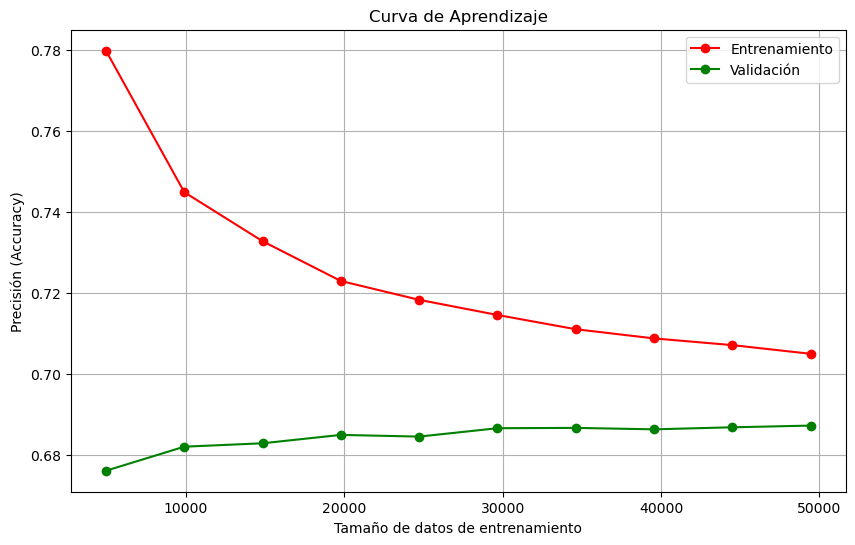

Accuracy promedio (Validación Cruzada): 0.69


In [590]:
from sklearn.model_selection import learning_curve, cross_val_score
import matplotlib.pyplot as plt
import numpy as np

# 1. Evaluar rendimiento en entrenamiento y test
train_accuracy = xgb_model.score(X_train_selected, y_train)
test_accuracy = xgb_model.score(X_test_selected, y_test)

print(f"Accuracy en entrenamiento: {train_accuracy:.2f}")
print(f"Accuracy en test: {test_accuracy:.2f}")

# 2. Curvas de Aprendizaje
train_sizes, train_scores, test_scores = learning_curve(
    xgb_model, X_train_selected, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validación')
plt.xlabel('Tamaño de datos de entrenamiento')
plt.ylabel('Precisión (Accuracy)')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.grid()
plt.show()

# 3. Validación Cruzada
cv_scores = cross_val_score(xgb_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print(f"Accuracy promedio (Validación Cruzada): {np.mean(cv_scores):.2f}")


In [593]:
print(xgb_model.feature_names_in_) 
#Columnas que se han usado para entrenar

['Lead Number' 'Total Time Spent on Website' 'Page Views Per Visit'
 'A free copy of Mastering The Interview' 'TotalVisits'
 'Average Time Per Visit' 'rn' 'Lead Origin_Landing Page Submission'
 'Last Activity_Email Opened' 'Specialization_Finance Management'
 'Specialization_Human Resource Management'
 'Specialization_Marketing Management'
 'What is your current occupation_Unemployed' 'Tags_Other Tags'
 'Tags_Ringing' 'Tags_Will revert after reading the email' 'City_Mumbai'
 'City_Select' 'Last Notable Activity_Modified'
 'Last Notable Activity_SMS Sent']


In [625]:
import numpy as np
import pandas as pd

# Crear un DataFrame de prueba con valores variados
data_prueba = pd.DataFrame({
    'Lead Number': [10001, 10002, 9999999, 8888888, 10005],
    'Total Time Spent on Website': [2500, 30, 4000, 3000, 50],  # Variado
    'Page Views Per Visit': [10, 1, 5, 8, 2],
    'A free copy of Mastering The Interview': [1, 0, 0, 0, 0],  # Si/No
    'TotalVisits': [20, 1, 10, 15, 2],
    'Average Time Per Visit': [120, 20, 70, 90, 25],
    'Lead Origin_Landing Page Submission': [1, 0, 1, 1, 0],
    'Last Activity_Other Last Activity': [0, 1, 1, 0, 1],
    'Specialization_Finance Management': [1, 0, 1,1 , 0],
    'Specialization_Human Resource Management': [0, 0, 0, 0, 0],
    'Specialization_Marketing Management': [0, 1, 0, 0, 1],
    'Specialization_Unknown': [0, 0, 1, 0, 1],
    'What is your current occupation_Unemployed': [1, 0, 0, 0, 0],
    'Tags_Other Tags': [0, 0, 1, 0, 0],
    'Tags_Ringing': [1, 0, 0, 1, 0],
    'Tags_Will revert after reading the email': [0, 1, 0, 0, 1],
    'City_Mumbai': [1, 0, 1, 1, 1],
    'City_Select': [0, 1, 0, 0, 0],
    'Last Notable Activity_Modified': [1, 0, 1, 0, 0],
    'Last Notable Activity_SMS Sent': [0, 1, 0, 1, 1]
})

# Añadir columnas que faltan
faltan_columnas = ['rn', 'Last Activity_Email Opened']
for col in faltan_columnas:
    if col not in data_prueba.columns:
        data_prueba[col] = 0  # Se agrega con valor 0 por defecto

# Asegurar que las columnas del DataFrame coinciden con las del modelo entrenado
columnas_entrenamiento = xgb_model.feature_names_in_
data_prueba = data_prueba[columnas_entrenamiento]

# Realizar predicciones con el modelo entrenado
predicciones = xgb_model.predict(data_prueba)
predicciones_proba = xgb_model.predict_proba(data_prueba)[:, 1]  # Probabilidad de convertir

# Mostrar resultados
data_prueba['Predicción'] = predicciones
data_prueba['Probabilidad de Conversión'] = np.round(predicciones_proba, 2)

print(data_prueba[['Lead Number', 'Predicción', 'Probabilidad de Conversión']])

#FINAL

   Lead Number  Predicción  Probabilidad de Conversión
0        10001           0                        0.45
1        10002           0                        0.45
2      9999999           0                        0.44
3      8888888           1                        0.61
4        10005           0                        0.47
